<a href="https://colab.research.google.com/github/martaldsantos/DMDSAA/blob/master/DM_Reestruturado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Libraries & Packages

In [6]:
!pip install category_encoders
#pip install category_encoders

     |████████████████████████████████| 81kB 3.7MB/s 


In [7]:
import pandas as pd
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from math import ceil
from pandas_profiling import ProfileReport
import scipy.cluster.hierarchy as shc
from sklearn import datasets
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import warnings
warnings.filterwarnings("ignore")

#from factor_analyzer import FactorAnalyzer
#from factor_analyzer import calculate_bartlett_sphericity
#from factor_analyzer import calculate_kmo

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##### Functions

In [8]:
def empty_space_Value_to_binary(df, column, value):
    '''
    This function turns a binary variable with values ' ' or any given string in to 0 or 1
    It needs as input the dataframe, the column name and the string symbolizing 1
    (column name and value needs to be between '')
    '''
    df[column] = df[column].map(lambda x: 1 if x == value else 0 if (x == ' ') else x)

def from_object_to_datetime(df, column):
    
    df[column] = pd.to_datetime(df[column], infer_datetime_format=True)

def x_to_bin(df, column): #from sim/nao to binary values
    
    df[column] = df[column].map(lambda x: 1 if x == 'X' else 0)
    
def gender_treatment(df, column): #os valores de U (unknown) e todos os outros valores que n tinham significado algum, vamos por como np.nan
 
    df[column] = df[column].replace(['A', 'U', 'C', ' '], np.nan)

def pandas_profiling(df, title):
    
    profile = ProfileReport(df,
                           title = title,
                           correlations = {'pearson' : {'calculate' : True},
                                          'spearman' : {'calculate' : False},
                                          'kendall' : {'calculate' : False},
                                          'phi_k' : {'calculate' : False},
                                          'cramers' : {'calculate' : False}})
    return profile.to_notebook_iframe()

def pandas_profiling_minimal(df, title):
    
    profile = ProfileReport(df,
                           title = title,
                           minimal = True)
    return profile.to_notebook_iframe()
    
def pandas_profiling_binary(df, title):
    
    profile = ProfileReport(df,
                           title = title,
                           correlations = {'pearson' : {'calculate' : False},
                                          'spearman' : {'calculate' : True},
                                          'kendall' : {'calculate' : False},
                                          'phi_k' : {'calculate' : False},
                                          'cramers' : {'calculate' : False}})
    return profile.to_notebook_iframe()

def hist_box_maker(df,titl, num_of_rows, figx, figy):
    
    fig, axes = plt.subplots(num_of_rows, ceil((len(df.columns)*2)/num_of_rows), figsize=(figx, figy))
    temp = (list(df.columns)*2)
    temp.sort()
    # Plot data
    # Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
    i = 0 
    for ax, feat in zip(axes.flatten(), temp):
        
        if i%2 == 0:
            ax.hist(df[feat], bins = 100)
            ax.set_title(feat, y=-0.13)
            pltiswork=feat
            
        else:
            sns.boxplot(x=df[pltiswork], ax = ax)
        
        i+=1
            
    # Layout
    # Add a centered title to the figure:
    title = titl

    plt.suptitle(title)

    plt.show()# All Numeric Variables' Box Plots in one figure
    
def iqr_X(df, X): #Compute IQR

    q1 = df.quantile(.25)
    q3 = df.quantile(.75)

    iqr = (q3 - q1)

    #Compute upper and lower limits
    lower_lim = q1 - X * iqr
    upper_lim = q3 + X * iqr

    filters = []

    for metric in df.columns:
        llim = lower_lim[metric]
        ulim = upper_lim[metric]
        filters.append(df[metric].between(llim, ulim, inclusive = True))
    
    return np.all(filters, 0)

def ohe(df, column_list):
    ohc = OneHotEncoder(sparse = False)
    ohc_feat = ohc.fit_transform(df[column_list])
    ohc_feat_names = ohc.get_feature_names()
    ohc_df = pd.DataFrame(ohc_feat, index = df.index, columns = ohc_feat_names)
    return ohc_df

def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table


# 1. Selection


In [9]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1Ob8eKK0ajYN6YCwM9XTUeyevLwTn3T_F"})   # replace the id with id of file you want to access
downloaded.GetContentFile('donors.csv')
df = pd.read_csv("donors.csv")

**[EXPLICAR O PORQUÊ DA DIVISÃO DOS DADOS]**

In [ ]:
df = pd.read_csv("donors.csv")

In [26]:
users_data = df[['ODATEDW', 'OSOURCE', 'TCODE', 'STATE', 'ZIP',
                 'MAILCODE', 'PVASTATE', 'DOB', 'NOEXCH', 'RECINHSE', 'RECP3',
                 'RECPGVG', 'RECSWEEP', 'MDMAUD', 'DOMAIN', 'HOMEOWNR', 'CHILD03',
                 'CHILD07', 'CHILD12', 'CHILD18', 'NUMCHLD', 'INCOME', 'GENDER',
                 'WEALTH1', 'HIT', 'MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT',
                 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH',
                 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP', 'PEPSTRFL', 'GEOCODE2' ,'DATASRCE',
                  'MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV',
                  'STATEGOV', 'FEDGOV', 'SOLP3', 'SOLIH', 'MAJOR', 'WEALTH2',
                  'GEOCODE', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE',
                  'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS',
                  'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS',
                  'PLATES', 'LIFESRC']].copy()

In [14]:
neighbourhood = df[['POP901', 'POP902', 'POP903',
                    'POP90C1', 'POP90C2', 'POP90C3', 'POP90C4', 'POP90C5', 'ETH1',
                    'ETH2', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9',
                    'ETH10', 'ETH11', 'ETH12', 'ETH13', 'ETH14', 'ETH15', 'ETH16',
                    'AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906',
                    'AGE907', 'CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3',
                    'AGEC4', 'AGEC5', 'AGEC6', 'AGEC7', 'CHILC1', 'CHILC2', 'CHILC3',
                    'CHILC4', 'CHILC5', 'HHAGE1', 'HHAGE2', 'HHAGE3', 'HHN1', 'HHN2',
                    'HHN3', 'HHN4', 'HHN5', 'HHN6', 'MARR1', 'MARR2', 'MARR3', 'MARR4',
                    'HHP1', 'HHP2', 'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'DW7',
                    'DW8', 'DW9', 'HV1', 'HV2', 'HV3', 'HV4', 'HU1', 'HU2', 'HU3',
                    'HU4', 'HU5', 'HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5', 'HHD6',
                    'HHD7', 'HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12', 'ETHC1',
                    'ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'ETHC6', 'HVP1', 'HVP2',
                    'HVP3', 'HVP4', 'HVP5', 'HVP6', 'HUR1', 'HUR2', 'RHP1', 'RHP2',
                    'RHP3', 'RHP4', 'HUPA1', 'HUPA2', 'HUPA3', 'HUPA4', 'HUPA5',
                    'HUPA6', 'HUPA7', 'RP1', 'RP2', 'RP3', 'RP4', 'MSA', 'ADI', 'DMA',
                    'IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC7', 'IC8', 'IC9',
                    'IC10', 'IC11', 'IC12', 'IC13', 'IC14', 'IC15', 'IC16', 'IC17',
                    'IC18', 'IC19', 'IC20', 'IC21', 'IC22', 'IC23', 'HHAS1', 'HHAS2',
                    'HHAS3', 'HHAS4', 'MC1', 'MC2', 'MC3', 'TPE1', 'TPE2', 'TPE3',
                    'TPE4', 'TPE5', 'TPE6', 'TPE7', 'TPE8', 'TPE9', 'PEC1', 'PEC2',
                    'TPE10', 'TPE11', 'TPE12', 'TPE13', 'LFC1', 'LFC2', 'LFC3', 'LFC4',
                    'LFC5', 'LFC6', 'LFC7', 'LFC8', 'LFC9', 'LFC10', 'OCC1', 'OCC2',
                    'OCC3', 'OCC4', 'OCC5', 'OCC6', 'OCC7', 'OCC8', 'OCC9', 'OCC10',
                    'OCC11', 'OCC12', 'OCC13', 'EIC1', 'EIC2', 'EIC3', 'EIC4', 'EIC5',
                    'EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC10', 'EIC11', 'EIC12', 'EIC13',
                    'EIC14', 'EIC15', 'EIC16', 'OEDC1', 'OEDC2', 'OEDC3', 'OEDC4',
                    'OEDC5', 'OEDC6', 'OEDC7', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5',
                    'EC6', 'EC7', 'EC8', 'SEC1', 'SEC2', 'SEC3', 'SEC4', 'SEC5', "VC1", "VC2",
                    'VC3', 'VC4', 'ANC1', 'ANC2', 'ANC3', 'ANC4', 'ANC5', 'ANC6',
                    'ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13',
                    'ANC14', 'ANC15', 'POBC1', 'POBC2', 'LSC1', 'LSC2', 'LSC3', 'LSC4',
                    'VOC1', 'VOC2', 'VOC3', 'HC1', 'HC2', 'HC3', 'HC4', 'HC5', 'HC6',
                    'HC7', 'HC8', 'HC9', 'HC10', 'HC11', 'HC12', 'HC13', 'HC14',
                    'HC15', 'HC16', 'HC17', 'HC18', 'HC19', 'HC20', 'HC21', 'MHUC1',
                    'MHUC2', 'AC1', 'AC2']].copy()

In [15]:
rfa = df[[ 'ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5',
           'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11',
           'ADATE_12', 'ADATE_13', 'ADATE_14', 'ADATE_15', 'ADATE_16',
           'ADATE_17', 'ADATE_18', 'ADATE_19', 'ADATE_20', 'ADATE_21',
           'ADATE_22', 'ADATE_23', 'ADATE_24', 'RFA_2', 'RFA_3', 'RFA_4',
           'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_10', 'RFA_11',
           'RFA_12', 'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16', 'RFA_17',
           'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22', 'RFA_23',
           'RFA_24', 'CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12',
           'NUMPRM12', 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7',
           'RDATE_8', 'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12',
           'RDATE_13', 'RDATE_14', 'RDATE_15', 'RDATE_16', 'RDATE_17',
           'RDATE_18', 'RDATE_19', 'RDATE_20', 'RDATE_21', 'RDATE_22',
           'RDATE_23', 'RDATE_24', 'RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6',
           'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11',
           'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16',
           'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21',
           'RAMNT_22', 'RAMNT_23', 'RAMNT_24', 'RAMNTALL', 'NGIFTALL',
           'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE',
           'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG',
           'AVGGIFT', 'CONTROLN', 'HPHONE_D', 'RFA_2R', 'RFA_2F', 'RFA_2A',
           'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']].copy()

# 2. Processing

### Users Data 

###### **Descriptive Statistics**

In [27]:
users_data.describe()

,TCODE,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2
count,95412.000000,12386.000000,74126.000000,50680.000000,95412.000000,42558.000000,42558.000000,42558.000000,42498.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,42558.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,51589.000000
mean,54.223117,1.527773,3.886248,5.345699,3.321438,0.152075,0.059166,1.116382,0.063932,0.448329,0.126322,0.065722,0.141806,0.145237,0.714484,0.237723,0.376239,0.005874,0.237558,1.048443,30.445332,29.702312,32.637719,6.842326,4.568566,3.110867,4.954525
std,953.844476,0.806861,1.854960,2.742490,9.306899,0.470023,0.262078,1.669967,0.297344,0.821010,0.380916,0.276398,0.490414,0.427822,1.249891,0.728572,0.959573,0.077942,0.878639,5.065522,11.470554,15.097752,17.709065,4.391699,5.126618,4.155168,2.802759
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,20.000000,21.000000,4.000000,1.000000,1.000000,3.000000
50%,1.000000,1.000000,4.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,29.000000,32.000000,6.000000,3.000000,2.000000,5.000000
75%,2.000000,2.000000,5.000000,8.000000,3.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,39.000000,43.000000,9.000000,6.000000,4.000000,7.000000
max,72002.000000,7.000000,7.000000,9.000000,241.000000,6.000000,4.000000,9.000000,6.000000,9.000000,5.000000,4.000000,5.000000,6.000000,9.000000,8.000000,9.000000,2.000000,9.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,87.000000,9.000000


General information about the data types, missing values and the shape of columns

In [28]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Data columns (total 73 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ODATEDW   95412 non-null  object 
 1   OSOURCE   95412 non-null  object 
 2   TCODE     95412 non-null  int64  
 3   STATE     95412 non-null  object 
 4   ZIP       95412 non-null  object 
 5   MAILCODE  95412 non-null  object 
 6   PVASTATE  95412 non-null  object 
 7   DOB       71529 non-null  object 
 8   NOEXCH    95412 non-null  object 
 9   RECINHSE  95412 non-null  object 
 10  RECP3     95412 non-null  object 
 11  RECPGVG   95412 non-null  object 
 12  RECSWEEP  95412 non-null  object 
 13  MDMAUD    95412 non-null  object 
 14  DOMAIN    95412 non-null  object 
 15  HOMEOWNR  95412 non-null  object 
 16  CHILD03   95412 non-null  object 
 17  CHILD07   95412 non-null  object 
 18  CHILD12   95412 non-null  object 
 19  CHILD18   95412 non-null  object 
 20  NUMCHLD   12386 non-null  fl

Now let's inspect the variable that has the unique identifier of each donor (CONTROLN). Let's check if there is more than 1 value for each identifier:

In [29]:
(rfa["CONTROLN"].value_counts()>1).sum() 

0

No, we will never have 2 lines with the same identifier, so we guarantee that the ID is unique.

###### **The 50 States**

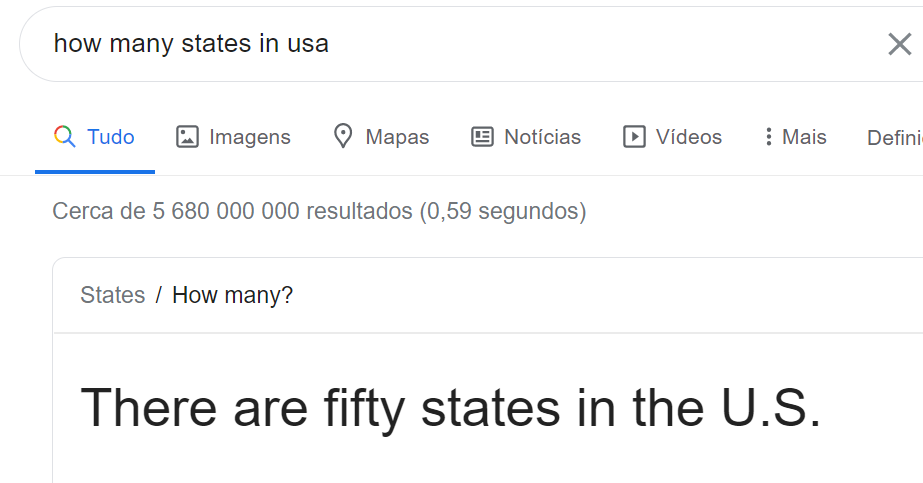

There are more values for the states than the number of states that google states exist indeed 


In [30]:
len(users_data["STATE"].unique())

57

Let's try to see the values to check what is wrong :

In [31]:
users_data["STATE"].unique()

array(['IL', 'CA', 'NC', 'FL', 'AL', 'IN', 'LA', 'IA', 'TN', 'KS', 'MN',
       'UT', 'MI', 'MO', 'TX', 'OR', 'WA', 'WI', 'GA', 'OK', 'SC', 'KY',
       'MD', 'SD', 'NV', 'NE', 'AZ', 'VA', 'ND', 'AK', 'AR', 'NM', 'MT',
       'MS', 'AP', 'CO', 'AA', 'HI', 'ME', 'WY', 'ID', 'OH', 'NJ', 'MA',
       'VT', 'NY', 'PA', 'DC', 'AE', 'CT', 'DE', 'WV', 'RI', 'GU', 'AS',
       'NH', 'VI'], dtype=object)

We have an array with the initials of the states and Washington DC, which isn't exactly  a state but due to its importance its many times counted as such

In [32]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

Now let's compare the values that were in the States list with the values in our dataset, and see which values are different:

In [33]:
users_data["STATE"].loc[(~users_data["STATE"].isin(states))].value_counts()

AP    81
AA    18
AE    15
VI     5
GU     4
AS     1
Name: STATE, dtype: int64

(https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations)

- **AP**, **AA** and **AE** are US Military Mail Codes 
- **VI** stands for Virgin Islands
- **GU** stands for Guam, an island in the pacific
-**AS** is from American Samoa

These values are called **"USA Territories"** and not exactly states.
We should consider renaming the variable for more accurate results

###### **Income Analysis**

In [36]:
users_data[['WEALTH1', "WEALTH2", "INCOME"]].isna().sum()

WEALTH1    44732
WEALTH2    43823
INCOME     21286
dtype: int64

In [37]:
(users_data[users_data['WEALTH1'].isna() & users_data['WEALTH2'].isna()].shape[0]) / users_data.shape[0]

0.22893346748836624

As we can see both wealth variables have a lot of missing values, however if we combine both, we will have 22% of observations which will need their values imputed.

- *WEALTH1* is prefered to *WEALTH2*, since *WEALTH2* is dependent on the donors state, so when we have observations with values in both, we would prefer the WEALTH1 value. We know this isn't ideal but it is better than imputing an estimated value.

- However, *WEALTH2* represents the median family income, and the metadata isn't really clear about what does *WEALTH1* refere to.

- The variable *INCOME* is interpreted as representing the total family income of each donor. The metadata isn't clear about it, but we believe it has a different bin distribuition, since it only has values between 1 and 7.

In [38]:
(users_data[users_data['WEALTH1'].isna() & users_data['WEALTH2'].isna() & users_data['INCOME'].isna()].shape[0]) / users_data.shape[0]

0.10936779440741207

If we also combine *INCOME* we will have 11% of missing values, but unfortunently, since they seem to show different bins, this isn't doable.

So let's see how many values are different between *WEALTH1* and *WEALTH2*.

In [39]:
(users_data[['WEALTH1', 'WEALTH2']][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))
                                  ].shape[0] /users_data.shape[0]) * 100

#10% of data points have different values of WEALTH1 and 2

10.57833396218505

But this percentage doesn't tell us how big is the difference between the values.

In [40]:
#Avg difference between different values of WEALTH1 and WEALTH2

(((users_data['WEALTH1'][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))] - users_data['WEALTH2'][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))])**2)**(1/2)).mean()

1.8562369959377787

In [41]:
#Std difference between different values of WEALTH1 and WEALTH2

(((users_data['WEALTH1'][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))] - users_data['WEALTH2'][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))])**2)**(1/2)).std()

1.5039385431617833

As we can see, when there is a difference between *WEALTH1*and *WEALTH2*, it is quite big (about more than one bin).

In [42]:
(users_data[users_data['INCOME'].isna()].shape[0] / users_data.shape[0]) * 100

22.30956273843961

If we use the variable *INCOME* we will have about 22% missing values, the same as the combination of *WEALTH1* and *WEALTH2*, and we don't have to combine any variables or take in to account assumptions we don't believe to be very strong.

So if we want to cluster having into account the income of the donors, we will use the total family income of each

In [43]:
users_data.drop(columns = ['WEALTH1', 'WEALTH2'], inplace = True)

###### **Variable Transformation**

We will turn the following variables that were in the string format but with binary values, in int64

In [44]:
empty_space_Value_to_binary(users_data, "MAILCODE", 'B')
empty_space_Value_to_binary(users_data, "PVASTATE", 'P')
empty_space_Value_to_binary(users_data, "HOMEOWNR", 'H')

users_data["PVASTATE"] = users_data["PVASTATE"].map(lambda x: 0 if x == 'E' else x)
users_data["HOMEOWNR"] = users_data["HOMEOWNR"].map(lambda x: 0 if x == 'U' else x)


users_data["PVASTATE"] = users_data["PVASTATE"].astype("int64")
users_data["HOMEOWNR"] = users_data["HOMEOWNR"].astype("int64")

As the values of MAILCODE reference a bad adress, we will rename the column to mean so.


In [45]:
users_data.rename(columns={"MAILCODE": "WRONG_ADRESS"}, inplace=True)

We can see that there are 1399 people that have no valid address, which is problematic since the gifts and promotions are sent by mail


In [46]:
users_data["WRONG_ADRESS"].value_counts()

0    94013
1     1399
Name: WRONG_ADRESS, dtype: int64

Put the following columns as binary. Special care had to be done to the variable NOEXCH which didnt have the values it should, and had values as strings and as ints. so the approach was to change everything to string and then to int, to be able to have a proper binary variable

In [47]:
for i in ["NOEXCH", "RECINHSE","RECP3","RECPGVG","RECSWEEP","PEPSTRFL"]:
    empty_space_Value_to_binary(users_data, i, 'X')

users_data["NOEXCH"] = users_data["NOEXCH"].astype('str')
users_data["NOEXCH"] = users_data["NOEXCH"].astype('int64')

Make the Variable Gender, Binary:


In [48]:
gender_treatment(users_data, "GENDER")

Use the function that automatically searches for the correct datetime to put our date variables in the right format:

In [49]:
for i in ["DOB","ODATEDW"]:
    from_object_to_datetime(users_data, i)

Some values had a strange "-" in the end which did not allow the variable to be numeric:

In [50]:
users_data["ZIP"] = users_data["ZIP"].str.replace('-', '') .astype("int64")

In this line we will put the null values that were formatted as " " in a proper format:


In [51]:
users_data[["CHILD03", "CHILD07", "CHILD12", "CHILD18", "GEOCODE2"]]= users_data[["CHILD03", "CHILD07", "CHILD12", "CHILD18","GEOCODE2"]].replace(" ", np.nan)

Put the unreadable values that were as "XXXX" in a proper format:


In [52]:
users_data["MDMAUD"] = users_data["MDMAUD"].replace("XXXX", np.nan)

We will divide the variable in GENDER in one that represents gender, and another one that represents the information in a Joint account

In [53]:
users_data['JOINT'] = np.where(users_data['GENDER']=='J', 1,0)
users_data['GENDER'] = users_data['GENDER'].replace(['J'], np.nan) #Change the values of joint acounts to unknown
users_data['FEMALE'] = users_data['GENDER'].map(lambda x: 1 if x == 'F' else 0 ) #And now we can create the variable female

 Let's turn the date of birth to a more readable variable: age of the referenced person in years.

In [54]:
users_data['AGE'] = users_data['DOB'].apply(lambda x : (pd.datetime.now().year - x.year))

The variable NUMCHLD has missing values. We decided to check whether the variable had 0s or not, and given that it doesn't, we will make the assumption that a missing value means that the person does not have a child and not the lack of information about the matter.

In [55]:
users_data["NUMCHLD"].value_counts()

1.0    7792
2.0    3110
3.0    1101
4.0     316
5.0      59
6.0       7
7.0       1
Name: NUMCHLD, dtype: int64

In [56]:
users_data["NUMCHLD"] = users_data["NUMCHLD"].replace(np.nan, 0)

In [57]:
users_data["DOMAIN"] = users_data["DOMAIN"].map(lambda x: np.nan if x ==" " else x)

In [58]:
users_data["URBANICITY"] = users_data["DOMAIN"].str[0:1]
users_data["SES"] = users_data["DOMAIN"].str[1:2]

In [59]:
users_data["SES"] = users_data["SES"].astype("float64")

In [60]:
for value in range(0,users_data.shape[0]):
  if users_data["URBANICITY"][value] == 'U':
    if users_data["SES"][value] ==3:
      users_data["SES"][value] =2
    if users_data["SES"][value] ==4:
      users_data["SES"][value] =3

We are going to drop the following variables:
- **CHILD03, CHILD07, CHILD12, CHILD18:** the variables have 98.8% of missing values and are not easy to interpret or put in a numeric format.
- **TCODE**: brings no information to the model. meaning, its impossible to encode and to even identify patterns with it.
-**OSOURCE**: No information is provided for us to be able to interpret the variables
- **GENDER**: We are going to drop this column because we have put its information in a more structured variable, FEMALE
- **DOMAIN**: We are going to drop this column because we have put its information in 2 other variables, URBANICITY, SES
- **MDMAUD**: We will remove this variable as its values are already decomposed later in the dataset and we don't want to have duplicate information


In [61]:
users_data= users_data.drop(columns = ["CHILD03", "CHILD07", "CHILD12", "CHILD18", "MDMAUD", "TCODE", "OSOURCE", "GENDER", "MDMAUD", "DOMAIN", "DOB"])

In [62]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
metric_features = users_data.select_dtypes(include=numerics)

###### **Encoding**

In [63]:
categorical = ['object']
categorical_features = users_data.select_dtypes(include=categorical)

In [64]:
categorical_features

,STATE,GEOCODE2,DATASRCE,SOLP3,SOLIH,MAJOR,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,URBANICITY
0,IL,C,,,,,,,,,,,,,,,,,,,,,,,,,T
1,CA,A,3,,,,02,,,,,,,,,,,,,,,,,,,,S
2,NC,C,3,,,,,,,,,,,,,,,,,,,,,,,,R
3,CA,C,3,,,,,,,,,,,,,,,,,,,,,,,,R
4,FL,A,3,,12,,,,,Y,Y,,,,Y,,,Y,,Y,,Y,,Y,,3,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,AK,C,,,,,,,,,,,,,,,,,,,,,,,,,C
95408,TX,A,3,,,,,,,,,,,,,,,,,,,,,,,,C
95409,MI,B,,,,,,,,,,,,,,,,,,,,,,,,,C
95410,CA,A,2,,12,,04,,,,,,,,,,,,,,,,,,,1,C


In [65]:
users_data["URBANICITY"].value_counts()

S    21924
R    19790
C    19689
T    19527
U    12166
Name: URBANICITY, dtype: int64

In [66]:
# create object of Ordinalencoding
encoder= ce.OrdinalEncoder(cols=['URBANICITY'],return_df=True, mapping=[{'col':'URBANICITY','mapping':{'R':0,'T':1,'S':2,'C':3,'U':4}}])

#fit and transform train data 
users_data = encoder.fit_transform(users_data)

In [67]:
users_data["URBANICITY"] = users_data["URBANICITY"].replace(-1,np.nan)

###### **Impute Missing Values**

In [68]:
missing_zero_values_table(users_data)

Your selected dataframe has 66 columns and 95412 Rows.
There are 19 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
MBCOLECT,40267,52914,55.5,93181,97.7,float64
PUBCULIN,37428,52854,55.4,90282,94.6,float64
MBGARDEN,40286,52854,55.4,93140,97.6,float64
MBBOOKS,21299,52854,55.4,74153,77.7,float64
MAGFAML,29790,52854,55.4,82644,86.6,float64
MAGFEM,37845,52854,55.4,90699,95.1,float64
MAGMALE,40036,52854,55.4,92890,97.4,float64
PUBGARDN,38388,52854,55.4,91242,95.6,float64
MBCRAFT,37707,52854,55.4,90561,94.9,float64
PUBHLTH,27309,52854,55.4,80163,84.0,float64


We decided to postpone the idea of imputing missing values in the variables that have information about the mailing promotions that the donors have responded to. So, we will proceed on doing the missing value imputation of the variables *AGE*, *INCOME*, *URBANICITY*, *SES*, *GEOCODE2*

In [ ]:
# Age& Income - KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")
users_data[["AGE", "INCOME"]] = imputer.fit_transform(users_data[["AGE", "INCOME"]])

In [ ]:
# Urbanicity e SES - KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")
users_data[["URBANICITY", "SES"]] = imputer.fit_transform(users_data[["URBANICITY", "SES"]])

In [ ]:
users_data["URBANICITY"].value_counts()

In [ ]:
users_data["SES"] = users_data["SES"].replace(1.865322,2)
users_data["URBANICITY"] = users_data["URBANICITY"].replace(1.837952,2)

In [ ]:
# GEOCODE2
users_data["GEOCODE2"]= users_data["GEOCODE2"].fillna(users_data["GEOCODE2"].mode()[0])

###### **Coherence Checks**

In [ ]:
users_data["TOTGIFT_NAN"]= users_data[['MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP']].sum(axis=1,  min_count=1)

In [ ]:
users_data[["HIT", "TOTGIFT_NAN"]].loc[users_data["HIT"] < users_data["TOTGIFT_NAN"]]

In [ ]:
users_data["HIT"][users_data["HIT"] < users_data["TOTGIFT_NAN"]] = users_data["TOTGIFT_NAN"][users_data["HIT"] < users_data["TOTGIFT_NAN"]] 

In [ ]:
users_data[["HIT", "TOTGIFT_NAN"]].loc[users_data["HIT"] < users_data["TOTGIFT_NAN"]]

###### **Correlation Matrix and Descriptive Statistics**

In [ ]:
users_corr=metric_features.corr(method = "spearman")
plt.figure(figsize=(20,20))
sns.heatmap(data = users_corr, annot = True, cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt='.2',  vmin=-1, vmax=1, center=0,square=True )


In [ ]:
users_data.dtypes

In [ ]:
users_data = users_data.drop(columns = ['RECSWEEP', 'MBBOOKS'])

#####**Is our data adequate to embrace a Principal Components Analysis?** 

https://www.earthinversion.com/geophysics/exploratory-factor-analysis/#bartletts-test

PCA means that essentially every output variable depends to some degree on every input variable. So after projection, the entire vector would become NaN. Intuitively, a missing value (that you cannot impute as 0) means there is some direction that you can move your point arbitrarily. But because you can still move the point, you don't know it's position in any of the coordinates - it could be anywhere.
PCA makes mostly sense on low-dimensional continuous data. your description of the data does not sound as if PCA is appropriate to use here.

**Bartlett’s Test**

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, we should not employ a factor analysis.

**Interpretability:** Small values *(less than 0.05)* of the significance level indicate that a factor analysis may be useful with your data


In [ ]:
# chi_square_value,p_value = calculate_bartlett_sphericity()
# chi_square_value,p_value

**Kaiser-Meyer-Olkin (KMO) Test**

It's a statistic that indicates the proportion of variance in our variables that might be caused by underlying factors. High values (close to 1.0) generally indicate that a factor analysis may be useful with our data. 

**Interpretability:** If the value is *less than 0.60*, the results of the factor analysis probably won’t be very useful.


In [ ]:
# kmo_all,kmo_model = calculate_kmo()
# kmo_model

Hierarchical Methods:
- R Square Comparison (Lab 8 tal e qual)
- Dendrogram tambén
- Stistics for Variables (também no final do Lab8)

### Third Party

In [25]:
third_party.head()

NameError: ignored

 Variables to immediately delete

DATASRCE -- Indicates which third-party data source the donor matched against

LIFESRC -- Indicates source of the lifestyle variables listed above

These variables don't give usefull information regarding our study


GEOCODE -- Geo Cluster Code indicating the level geography at which a record matches the census data.

This variable could possible be usefull, but unfortunently it has over 80% missing values.

In [ ]:
(third_party['GEOCODE'][third_party['GEOCODE'] == ' '].shape[0] / third_party.shape[0]) * 100 #Percent of poddible missing values

In [ ]:
third_party.drop(columns = ['DATASRCE', 'LIFESRC', 'GEOCODE'], inplace = True)

In [ ]:
third_party.columns

In [ ]:
third_party.dtypes

In [ ]:
third_party[['MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV']].describe()

MALEMILI, MALEVET, VIETVETS, WWIIVETS, LOCALGOV, STATEGOV, FEDGOV

These variable don't need any "initial" treating, however the documentation is ambiguos about what they refer to. It seems they migth refer to the donor's household or neighborhood, for now we will keep them, however, if we use them later, we will need to clearly define what we believe they indicate

SOLP3 -- SOLICIT LIMITATION CODE P3 

SOLIH -- SOLICITATION LIMIT CODE IN HOUSE

These variables seem usefull, however I can't tell the difference between one and the other, I have to ask the professors.

The values are categorical, however they can be easely turned in to integer values as they do have an order, except of course for the default value, wich is also the most prevolant one in both variables, by a lot.

Some special transformations will be needed for these variables, however I doubt they will be usefull due to their distribuition.

Since the great majority of values is the default one, they don't allow us to discretize the donors that well, so we will delte them.

In [ ]:
third_party['SOLP3'].value_counts()

In [ ]:
third_party['SOLP3'].isna().sum()

In [ ]:
third_party['SOLIH'].value_counts()

In [ ]:
third_party['SOLIH'].isna().sum()

In [ ]:
third_party.drop(columns = ['SOLP3', 'SOLIH'], inplace = True)

MAJOR -- Major Donor Flag

We already have "this information" in other variables, however it is nice to have it on a binary one. But we have to be carefull not to repeat information.

We turned the variable in to a binary one.

In [ ]:
empty_space_Value_to_binary(third_party, 'MAJOR', 'X') #Turns variable into binary format

In [ ]:
third_party['MAJOR'].value_counts()

WEALTH2 -- Wealth Rating Wealth rating uses median family income and population statistics from each area to index relative wealth within each state The segments are denoted 0-9, with 9 being the highest income group and zero being the lowest. Each rating has a different meaning within each state.

Since comparisons can only be made regarding individuals of the same state, the use of this variable can be dubious. But for now we will keep it since it can be an important indicator, even though it has almost 50% missing values.

If we do use it, no treatment is needed.

In [ ]:
(third_party['WEALTH2'].isna().sum() / third_party.shape[0]) * 100 #Percent missing values

In [ ]:
third_party['WEALTH2'].value_counts()

COLLECT1, VETERANS, BIBLE, CATLG, HOMEE, PETS, CDPLAY, STEREO, PCOWNERS, PHOTO, CRAFTS, FISHER, GARDENIN, BOATS, WALKER, KIDSTUFF, CARDS, PLATES

All these variables about the donors interests or hobbies don't have missing values

Since theyre values are all string, we will apply a function  to turn them into binary variables

In [ ]:
third_party[['COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY',
             'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS',
             'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES']].isna().sum()

In [ ]:
#Turns variables into binary format
for i in ['COLLECT1','VETERANS','BIBLE','CATLG','HOMEE',
          'PETS','CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS',
          'FISHER','GARDENIN','BOATS', 'WALKER', 'KIDSTUFF','CARDS','PLATES']:
    empty_space_Value_to_binary(third_party, i, 'Y')

In [ ]:
third_party.dtypes

#Just to see if all the dtypes are now correct

A income analysis tem de ser dps disto!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
N pode ser antes ne!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Feature Selection trough Correlation Matrix

No variables with high correlation

In [ ]:
(third_party.isna().sum() / third_party.shape[0]) * 100 #Percent missing values

In [ ]:
third_party_corr = third_party.corr(method = "spearman")
plt.figure(figsize=(20,20))
sns.heatmap(data = third_party_corr, annot = True, cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt='.2',  vmin=-1, vmax=1, center=0,square=True )

Outliers

In [ ]:
third_party[(third_party['FEDGOV']>55)|
            (third_party['LOCALGOV']>43)|
            (third_party['MALEMILI']>63)|
            (third_party['MALEVET']>87)|
            (third_party['STATEGOV']>63)|
            (third_party['VIETVETS']>95)]

In [ ]:
third_party.columns

In [ ]:
#Para ver se quisermos eliminar variáveis binárias por isto

for i in ['MAJOR', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG',
       'HOMEE', 'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS',
       'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES']:
    
    print(i, ':', third_party[i].value_counts(), '\n')

Joining third_party and user_data

In [ ]:
users_data = users_data.join(third_party, how = 'inner') #Joins both dataframes, since no observations were deleted, indexes remain the same

In [ ]:
users_data.shape

### RFA


When it comes to the promotions sent and gifts received, we can divide the data in to 6 groups.

ADATE_X's,

RFA_X's,

Aggregations or derivates of the above two groups,

RDATE_X's,

RAMNT_X's,

Aggregations or derivates of the above two groups.

Let's first take care of the aggregations or derivatives variables, as these will probably be the ones we will work with the most, since the other ones are to specific, which is great to do some coherence checks or create other variables, but not to cluster with.

In [1]:
#Typecast all of the date variables to their correct dtype

for i in ['ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7',
       'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13',
       'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17', 'ADATE_18', 'ADATE_19',
       'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24', "MAXADATE", 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24', "MINRDATE", "MAXRDATE", "LASTDATE", "FISTDATE", "NEXTDATE"]:
    rfa[i] =  pd.to_datetime(rfa[i], infer_datetime_format=True)

NameError: ignored

In [2]:
rfa[['CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12']].head() #The values seem fine

NameError: ignored

In [ ]:
rfa[['CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12']].isna().sum() #No missing values

No incoherences of the type number of promotions received in the last 12 months being higher than in the lifetime.

In [ ]:
rfa[(rfa['CARDPROM'] < rfa['CARDPM12']) | (rfa['NUMPROM'] < rfa['NUMPRM12'])].shape[0]

Nothing seems out of the ordinary, looking at the mean, std and min and max values maybe some outliers, but we will check this better latter.

Most important is that there are no weird negative values

In [ ]:
rfa[['CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12']].describe()

All of the types are correct

In [ ]:
rfa[['CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12']].dtypes

In [ ]:
rfa[['RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']].head()

All of the dtypes seem to be correct except the TIMELAG one, it should be int since the variable corresponds to the number of months between the first and second gift

In [ ]:
rfa[['RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']].dtypes

As we can see this is because of missing values.

But are these actual missing values or observations were a donor simply gave just one gift?

In [ ]:
rfa['TIMELAG'].isna().sum()

As we can see all of the TIMELAG missing values are observations were a donor simply gave on gift.

So we can't just impute these missing values, we have to change them in to something if we want to use this variable.

**Ainda nada foi feito quanto a isto**

In [ ]:
rfa[(rfa['TIMELAG'].isna()) & (rfa['NGIFTALL'] == 1)].shape[0]

However there are some observations were only one gift was donated but a value for TIMELAG exists

In [ ]:
rfa[rfa['NGIFTALL'] == 1 & ~(rfa['TIMELAG'].isna())].shape[0]

When this value is zero, this means that just one donation was made but there is a value for NEXTDATE and it is the same as the FISTDATE. We could leave them , we just have to be carefull when interpreting zeros in this variable, as they can mean both someone who just donated once or someone who made the first two donations on the same day. If we leave these two interpretations open we can also change the missing values of TIMELAG, wich all correspond to someone who made just one gift, to zero.

Or we can delete all of these observations, making sure that there isn't any possibility of a wrong assumption being made.

The bigger problem is when someone made just one donation but the TIMELAG isn't zero. These values for sure need to be deleted.

In [ ]:
(rfa['TIMELAG'][rfa['NGIFTALL'] == 1 & ~(rfa['TIMELAG'].isna())] == 0).value_counts()

Since there are so few values that have this problem we will just delete all of them to be sure we aren't doing any assumption that jeperdizes our analysis.

In [ ]:
#############################################################

rfa = rfa[~(rfa['NGIFTALL'] == 1 & ~(rfa['TIMELAG'].isna()))]

There are also some observations were the TIMELAG is zero but more than one gift was given.

In [ ]:
rfa[(rfa['TIMELAG'] == 0) & (rfa['NGIFTALL'] > 1)].shape[0]

There are now 897 observations were supposedly the first gift was given in the same date as the second.

In [ ]:
rfa[rfa['FISTDATE'] == rfa['NEXTDATE']].shape[0]

And all of these dates have a TIMELAG of zero.

So we can assume that all of the observations were a donor gave more than one gift but the TIMELAG is zero are correct values, since, at least the first and second gift could be given on the same day.

In [ ]:
rfa[(rfa['FISTDATE'] == rfa['NEXTDATE']) & (rfa['TIMELAG'] == 0)].shape[0]

All of the other variables don't have any missing values, except FISTDATE, wich we will take care of later.

In [ ]:
rfa[['RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']].isna().sum()

And no incoherences seem to exist, at least of the type total number of promotions received being smaller than total number of card promotions, date of the first gift being more recent than date of the second gift and smallest donation done being more expensive than highest donation.

And through the describe function we can see that there are no weird negative values, and that some outlier detection migth be needed.

In [ ]:
rfa[(rfa['NGIFTALL'] < rfa['CARDGIFT']) | (rfa['FISTDATE'] > rfa['NEXTDATE']) | (rfa['MINRAMNT'] > rfa['MAXRAMNT'])].shape[0]

In [ ]:
rfa[['RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']].describe().T

As we can see both observations with missing values on FISTDATE have given a lot of gifts, have both values of the second gift given and have a clearly wrong value for TIMELAG. 1044 months is equivelent to 87 years, so it is safe to assume that we can drop these two records.

In [ ]:
rfa[['NGIFTALL', 'NEXTDATE', 'TIMELAG']][rfa['FISTDATE'].isna()]

In [ ]:
#####################################

rfa = rfa[~(rfa['FISTDATE'].isna())]

FISTDATE and ODATEDW supposedly have the same information, however in most observations this isn't the case, possibly due to the source of this variables being different.

Since we are not going to use directly any of this variables, and FISTDATE comes from the same source as all of the corresponding promotion and gifts variables, we will drop ODATEDW. Even though we wil also later drop or not use FISTDATE.

In [ ]:
rfa['FISTDATE'].isna().sum()

In [ ]:
users_data['ODATEDW'].isna().sum()

In [ ]:
users_data['ODATEDW'] = pd.to_datetime(users_data['ODATEDW'], infer_datetime_format=True)

In [ ]:
##########################É preciso por ODATEDW no rfa no início do notebook e alterar aqui######

#(users_data['ODATEDW'] != rfa['FISTDATE']).sum()

In [ ]:
#############Aqui tmb!!!!!!!!!!!!!!!!!!!!!!####################

#users_data.drop(columns = ['ODATEDW'], inplace = True)

Lastly we can see if the timelag value is correct.

And as we can see it is.

In [ ]:
((((rfa['NEXTDATE'].apply(lambda x: x.year) - rfa['FISTDATE'].apply(lambda x: x.year)) * 12 + rfa['NEXTDATE'].apply(lambda x: x.month) - rfa['FISTDATE'].apply(lambda x: x.month)) != rfa['TIMELAG']) & ~(rfa['TIMELAG'].isna()) & ~(rfa['NEXTDATE'].isna()) & ~(rfa['FISTDATE'].isna())).value_counts()

**ADATE_X, RDATE_X and LASTDATE Treatment**

As we can see we have a lot of missing values in most of these variables., which most likely correspond to promotions or gifts that weren't sent.

In [ ]:
rfa[['ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7',
       'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13',
       'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17', 'ADATE_18', 'ADATE_19',
       'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24', 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24']].isna().sum()

**Coherence Checks for the date variables**

The recency code, for the most recent promotion date, tells us every donor was a lapsed donor at the date the promotion was sent

The promotion was sent on 2017, either on the first of june or first of april. 

To see if this information is correct we can try and see if any donor's gift had been received less than 13 months prior to this donation being sent, and as we can see this didn't happen.

**However there are still some donors who sent a gift after receiving this promotion, should we delete them?**

In [ ]:
rfa['RFA_2R'].value_counts()

In [ ]:
rfa['ADATE_2'].value_counts()

In [ ]:
for i in ['RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24']:
    

    print(i, ((((rfa['ADATE_2'].apply(lambda x: x.year) - rfa[i].apply(lambda x: x.year)) * 12 + rfa['ADATE_2'].apply(lambda x: x.year) - rfa[i].apply(lambda x: x.year)) < 13) &(
    ((rfa['ADATE_2'].apply(lambda x: x.year) - rfa[i].apply(lambda x: x.year)) * 12 + rfa['ADATE_2'].apply(lambda x: x.year) - rfa[i].apply(lambda x: x.year)) > 0)).sum())

In [ ]:
rfa['LASTDATE'].isna().sum() #All donors have a LASTDATE

We can check wether there are any observations were the LASTDATE isn't more recent than RDATE_X.

In [ ]:
(rfa[(rfa['LASTDATE'] < rfa['RDATE_3']) |
     (rfa['LASTDATE'] < rfa['RDATE_4']) |
     (rfa['LASTDATE'] < rfa['RDATE_5']) |
     (rfa['LASTDATE'] < rfa['RDATE_6']) |
     (rfa['LASTDATE'] < rfa['RDATE_7']) |
     (rfa['LASTDATE'] < rfa['RDATE_8']) |
     (rfa['LASTDATE'] < rfa['RDATE_9']) |
     (rfa['LASTDATE'] < rfa['RDATE_10']) |
     (rfa['LASTDATE'] < rfa['RDATE_11']) |
     (rfa['LASTDATE'] < rfa['RDATE_12']) |
     (rfa['LASTDATE'] < rfa['RDATE_13']) |
     (rfa['LASTDATE'] < rfa['RDATE_14']) |
     (rfa['LASTDATE'] < rfa['RDATE_15']) |
     (rfa['LASTDATE'] < rfa['RDATE_16']) |
     (rfa['LASTDATE'] < rfa['RDATE_17']) |
     (rfa['LASTDATE'] < rfa['RDATE_18']) |
     (rfa['LASTDATE'] < rfa['RDATE_19']) |
     (rfa['LASTDATE'] < rfa['RDATE_20']) |
     (rfa['LASTDATE'] < rfa['RDATE_21']) |
     (rfa['LASTDATE'] < rfa['RDATE_22']) |
     (rfa['LASTDATE'] < rfa['RDATE_23']) |
     (rfa['LASTDATE'] < rfa['RDATE_24']) ].shape[0] / rfa.shape[0]) * 100

Only 0.08% of observations have this problem, we can just change the value of LASTDATE, guarantying that this is infact the last known date a donor gave a gift.

In [ ]:
rfa['LASTDATE'][(rfa['LASTDATE'] < rfa['RDATE_3']) |
     (rfa['LASTDATE'] < rfa['RDATE_4']) |
     (rfa['LASTDATE'] < rfa['RDATE_5']) |
     (rfa['LASTDATE'] < rfa['RDATE_6']) |
     (rfa['LASTDATE'] < rfa['RDATE_7']) |
     (rfa['LASTDATE'] < rfa['RDATE_8']) |
     (rfa['LASTDATE'] < rfa['RDATE_9']) |
     (rfa['LASTDATE'] < rfa['RDATE_10']) |
     (rfa['LASTDATE'] < rfa['RDATE_11']) |
     (rfa['LASTDATE'] < rfa['RDATE_12']) |
     (rfa['LASTDATE'] < rfa['RDATE_13']) |
     (rfa['LASTDATE'] < rfa['RDATE_14']) |
     (rfa['LASTDATE'] < rfa['RDATE_15']) |
     (rfa['LASTDATE'] < rfa['RDATE_16']) |
     (rfa['LASTDATE'] < rfa['RDATE_17']) |
     (rfa['LASTDATE'] < rfa['RDATE_18']) |
     (rfa['LASTDATE'] < rfa['RDATE_19']) |
     (rfa['LASTDATE'] < rfa['RDATE_20']) |
     (rfa['LASTDATE'] < rfa['RDATE_21']) |
     (rfa['LASTDATE'] < rfa['RDATE_22']) |
     (rfa['LASTDATE'] < rfa['RDATE_23']) |
     (rfa['LASTDATE'] < rfa['RDATE_24']) ] = rfa[['RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
                                                  'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14', 'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20', 'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24']][
    (rfa['LASTDATE'] < rfa['RDATE_3']) |
     (rfa['LASTDATE'] < rfa['RDATE_4']) |
     (rfa['LASTDATE'] < rfa['RDATE_5']) |
     (rfa['LASTDATE'] < rfa['RDATE_6']) |
     (rfa['LASTDATE'] < rfa['RDATE_7']) |
     (rfa['LASTDATE'] < rfa['RDATE_8']) |
     (rfa['LASTDATE'] < rfa['RDATE_9']) |
     (rfa['LASTDATE'] < rfa['RDATE_10']) |
     (rfa['LASTDATE'] < rfa['RDATE_11']) |
     (rfa['LASTDATE'] < rfa['RDATE_12']) |
     (rfa['LASTDATE'] < rfa['RDATE_13']) |
     (rfa['LASTDATE'] < rfa['RDATE_14']) |
     (rfa['LASTDATE'] < rfa['RDATE_15']) |
     (rfa['LASTDATE'] < rfa['RDATE_16']) |
     (rfa['LASTDATE'] < rfa['RDATE_17']) |
     (rfa['LASTDATE'] < rfa['RDATE_18']) |
     (rfa['LASTDATE'] < rfa['RDATE_19']) |
     (rfa['LASTDATE'] < rfa['RDATE_20']) |
     (rfa['LASTDATE'] < rfa['RDATE_21']) |
     (rfa['LASTDATE'] < rfa['RDATE_22']) |
     (rfa['LASTDATE'] < rfa['RDATE_23']) |
     (rfa['LASTDATE'] < rfa['RDATE_24']) ].max(axis = 1)

In theory, the LASTDATE should be one of the values of RDATE_X, however for 13% of observations this isn't the case.
But there is always the possibility that the last gift didn't correspond to any of the promotions we have on our dataset.

Since there are so many observations where this happens, we think the problem is in our initial assumption and not on the data itself.

In [ ]:
(rfa[(rfa['LASTDATE'] != rfa['RDATE_3']) &
     (rfa['LASTDATE'] != rfa['RDATE_4']) &
     (rfa['LASTDATE'] != rfa['RDATE_5']) &
     (rfa['LASTDATE'] != rfa['RDATE_6']) &
     (rfa['LASTDATE'] != rfa['RDATE_7']) &
     (rfa['LASTDATE'] != rfa['RDATE_8']) &
     (rfa['LASTDATE'] != rfa['RDATE_9']) &
     (rfa['LASTDATE'] != rfa['RDATE_10']) &
     (rfa['LASTDATE'] != rfa['RDATE_11']) &
     (rfa['LASTDATE'] != rfa['RDATE_12']) &
     (rfa['LASTDATE'] != rfa['RDATE_13']) &
     (rfa['LASTDATE'] != rfa['RDATE_14']) &
     (rfa['LASTDATE'] != rfa['RDATE_15']) &
     (rfa['LASTDATE'] != rfa['RDATE_16']) &
     (rfa['LASTDATE'] != rfa['RDATE_17']) &
     (rfa['LASTDATE'] != rfa['RDATE_18']) &
     (rfa['LASTDATE'] != rfa['RDATE_19']) &
     (rfa['LASTDATE'] != rfa['RDATE_20']) &
     (rfa['LASTDATE'] != rfa['RDATE_21']) &
     (rfa['LASTDATE'] != rfa['RDATE_22']) &
     (rfa['LASTDATE'] != rfa['RDATE_23']) &
     (rfa['LASTDATE'] != rfa['RDATE_24']) ].shape[0] / rfa.shape[0]) * 100

It doesn't make sense for a donor to give a gift regarding a promotion he hasn't received yet.

In [ ]:
(rfa[(rfa['RDATE_3'] < rfa['ADATE_3']) |
     (rfa['RDATE_4'] < rfa['ADATE_4']) |
     (rfa['RDATE_5'] < rfa['ADATE_5']) |
     (rfa['RDATE_6'] < rfa['ADATE_6']) |
     (rfa['RDATE_7'] < rfa['ADATE_7']) |
     (rfa['RDATE_8'] < rfa['ADATE_8']) |
     (rfa['RDATE_9'] < rfa['ADATE_9']) |
     (rfa['RDATE_10'] < rfa['ADATE_10']) |
     (rfa['RDATE_11'] < rfa['ADATE_11']) |
     (rfa['RDATE_12'] < rfa['ADATE_12']) |
     (rfa['RDATE_13'] < rfa['ADATE_13']) |
     (rfa['RDATE_14'] < rfa['ADATE_14']) |
     (rfa['RDATE_15'] < rfa['ADATE_15']) |
     (rfa['RDATE_16'] < rfa['ADATE_16']) |
     (rfa['RDATE_17'] < rfa['ADATE_17']) |
     (rfa['RDATE_18'] < rfa['ADATE_18']) |
     (rfa['RDATE_19'] < rfa['ADATE_19']) |
     (rfa['RDATE_20'] < rfa['ADATE_20']) |
     (rfa['RDATE_21'] < rfa['ADATE_21']) |
     (rfa['RDATE_22'] < rfa['ADATE_22']) |
     (rfa['RDATE_23'] < rfa['ADATE_23']) |
     (rfa['RDATE_24'] < rfa['ADATE_24']) ].shape[0] / rfa.shape[0]) * 100

0.8% of data points have this issue, so we will delete them.

In [ ]:
rfa = rfa[~((rfa['RDATE_3'] < rfa['ADATE_3']) |
     (rfa['RDATE_4'] < rfa['ADATE_4']) |
     (rfa['RDATE_5'] < rfa['ADATE_5']) |
     (rfa['RDATE_6'] < rfa['ADATE_6']) |
     (rfa['RDATE_7'] < rfa['ADATE_7']) |
     (rfa['RDATE_8'] < rfa['ADATE_8']) |
     (rfa['RDATE_9'] < rfa['ADATE_9']) |
     (rfa['RDATE_10'] < rfa['ADATE_10']) |
     (rfa['RDATE_11'] < rfa['ADATE_11']) |
     (rfa['RDATE_12'] < rfa['ADATE_12']) |
     (rfa['RDATE_13'] < rfa['ADATE_13']) |
     (rfa['RDATE_14'] < rfa['ADATE_14']) |
     (rfa['RDATE_15'] < rfa['ADATE_15']) |
     (rfa['RDATE_16'] < rfa['ADATE_16']) |
     (rfa['RDATE_17'] < rfa['ADATE_17']) |
     (rfa['RDATE_18'] < rfa['ADATE_18']) |
     (rfa['RDATE_19'] < rfa['ADATE_19']) |
     (rfa['RDATE_20'] < rfa['ADATE_20']) |
     (rfa['RDATE_21'] < rfa['ADATE_21']) |
     (rfa['RDATE_22'] < rfa['ADATE_22']) |
     (rfa['RDATE_23'] < rfa['ADATE_23']) |
     (rfa['RDATE_24'] < rfa['ADATE_24']))]

**RFA_x and RAMNT_X Treatment**

Descobrir coherence checks para estas variáveis ou então uma boa desculpa para n os fazermos!!!!!!!!!!!!!!!!!!!

In [ ]:
#separar todos os primeiros bytes de rfa e fazer colunas com numero de vezes em cada categoria

#falar que so vamos utilizar o ultimo estado total

All variables have the correct dtype.

No negative values, some outliers for sure, but if we are not going to use these variables, since the outliers seem to be correct values, just extreme, there is no point in removing the records.

There is one record were the value of the smallest donation is higher than one of the gifts given in one of the various promotions and 23 records were the highest donation is smaller than one of the gifts of the various promotions. So we will correct these values.

In [ ]:
rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']].dtypes

In [ ]:
rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']].describe().T

In [ ]:
rfa[(rfa['MINRAMNT'] > rfa['RAMNT_3']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_4']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_5']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_6']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_7']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_8']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_9']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_10']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_11']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_12']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_13']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_14']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_15']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_16']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_17']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_18']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_19']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_20']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_21']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_22']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_23']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_24'])].shape[0]

In [ ]:
#Pvf n apagar, dps explico

rfa['MINRAMNT'][(rfa['MINRAMNT'] > rfa['RAMNT_3']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_4']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_5']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_6']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_7']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_8']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_9']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_10']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_11']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_12']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_13']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_14']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_15']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_16']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_17']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_18']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_19']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_20']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_21']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_22']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_23']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_24'])] = rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']][(rfa['MINRAMNT'] > rfa['RAMNT_3']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_4']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_5']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_6']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_7']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_8']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_9']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_10']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_11']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_12']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_13']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_14']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_15']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_16']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_17']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_18']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_19']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_20']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_21']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_22']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_23']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_24'])].min(axis=1)

In [ ]:
rfa[(rfa['MAXRAMNT'] < rfa['RAMNT_3']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_4']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_5']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_6']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_7']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_8']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_9']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_10']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_11']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_12']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_13']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_14']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_15']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_16']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_17']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_18']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_19']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_20']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_21']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_22']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_23']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_24'])].shape[0]

In [ ]:
#Pvf n apagar, dps explico

rfa['MAXRAMNT'][(rfa['MAXRAMNT'] < rfa['RAMNT_3']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_4']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_5']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_6']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_7']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_8']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_9']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_10']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_11']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_12']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_13']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_14']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_15']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_16']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_17']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_18']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_19']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_20']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_21']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_22']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_23']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_24'])] = rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']][(rfa['MAXRAMNT'] < rfa['RAMNT_3']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_4']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_5']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_6']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_7']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_8']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_9']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_10']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_11']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_12']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_13']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_14']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_15']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_16']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_17']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_18']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_19']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_20']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_21']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_22']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_23']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_24'])].max(axis=1)

Lets sum all of the values of all the gifts given, and check whether the total dollar amount of gifts given is smaller than this.

A smaller value of total dollar amount of gifts given regarding the promotions than RAMNTALL is comprehensible, other donations regarding different promotions migth have been given, however a higher value is clearly wrong, we will delete the 16 records that have this problem.

In [ ]:
rfa['TOTL_GIFTS_AMOUNT'] = rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']].sum(axis = 1)

In [ ]:
(rfa['TOTL_GIFTS_AMOUNT'] > rfa['RAMNTALL']).sum()

In [ ]:
################################N eliminar, trocar

rfa = rfa[~(rfa['TOTL_GIFTS_AMOUNT'] > rfa['RAMNTALL'])]

We have the total amount of donations given, but we can also calculate the total amount of card donations given.

Card donations being the ones of the promotions FS, GK, TK, SK, NK, XK, UF, UU, just like defined on the metadata.

And the total amount of notepad donations, X1, G1.

And promotions with only labels or stickers, LL, WL, CC.

In [ ]:
rfa['TOTL_CARDGIFTS_AMOUNT'] = rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_8', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_18', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']].sum(axis = 1)

In [ ]:
(rfa['TOTL_CARDGIFTS_AMOUNT'] > rfa['RAMNTALL']).sum()

In [ ]:
rfa['TOTL_NTPADGIFTS_AMOUNT'] = rfa[['RAMNT_7', 'RAMNT_11', 'RAMNT_17', 'RAMNT_21']].sum(axis = 1)

In [ ]:
rfa['TOTL_LBLSTCKGIFTS_AMOUNT'] = rfa[['RAMNT_6', 'RAMNT_9', 'RAMNT_10', 'RAMNT_16', 'RAMNT_19', 'RAMNT_20']].sum(axis =1)

TUDO O Q ESTA ABAIXO AINDA N FOI TRABALHADO

In [ ]:
rfa.shape[0] / users_data.shape[0]

In [ ]:
#rfa.iloc[:,23:46] = rfa.iloc[:,23:46].replace(" ", np.nan)

#Pus so a comentario pq ainda n trabalhamos esta parte

In [ ]:
#####################################################################################################################
#################Ainda n mexi nestas colunas##################################################

rfa.iloc[:,110:116]

Feature selection of rfa trough correlation matrix

In [ ]:
rfa_metric_feat = rfa.drop(columns = ['ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7',
       'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13',
       'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17', 'ADATE_18', 'ADATE_19',
       'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24', "MAXADATE", 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24', "MINRDATE", "MAXRDATE", "LASTDATE", "FISTDATE", "NEXTDATE",
                   'RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24',
                   'RFA_2', 'RFA_3', 'RFA_4', 'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_10', 'RFA_11', 'RFA_12',
                   'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16', 'RFA_17', 'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22',
                   'RFA_23', 'RFA_24', 'RFA_2R', 'RFA_2F', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']).columns.to_list()

In [ ]:
rfa_corr = rfa[rfa_metric_feat].corr(method = "pearson")
plt.figure(figsize=(20,20))
sns.heatmap(data = rfa_corr, annot = True, cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt='.2',  vmin=-1, vmax=1, center=0,square=True )

Very high correlations between CARDPROM, NUMPROM, NGIFTALL and CARDGIFT, wich is very interesting!!
We will keep NGIFTALL for simplicity.
Between AVGGIFT and MINRAMNT, MAXRAMNT and LASTGIFT, we will keep AVGGIFT since it is highly correlated with the other three.
Between TOTL_CARDGIFTS_AMOUNT and TOTL_GIFTS_AMOUNT, we will drop TOTL_GIFTS_AMOUNT since we already have this information.

In [ ]:
rfa_after_treatment = rfa[rfa_metric_feat].drop(columns = ['CARDPROM', 'NUMPROM', 'CARDGIFT', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'TOTL_GIFTS_AMOUNT'])

Outliers

In [ ]:
rfa_after_treatment.columns

In [ ]:
hist_box_maker(rfa_after_treatment.drop(columns = ['HPHONE_D']),'RFA', 10, 20, 20)

In [ ]:
rfa_after_treatment[(rfa_after_treatment['AVGGIFT'] > 400) | (rfa_after_treatment['NGIFTALL'] > 100) | (rfa_after_treatment['NUMPRM12'] > 55) | (rfa_after_treatment['RAMNTALL'] > 3000) | (rfa_after_treatment['TIMELAG'] > 75) | (rfa_after_treatment['TOTL_CARDGIFTS_AMOUNT'] > 350) | (rfa_after_treatment['TOTL_LBLSTCKGIFTS_AMOUNT'] > 300) | (rfa_after_treatment['TOTL_NTPADGIFTS_AMOUNT'] > 200)]

### Neighbourhood Data

Since the neighborhood data has a lot of variables the treatment had to be done in a different way.
First we started by checking how many columns have missing values

In [ ]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

In [ ]:

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            #if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                # drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [ ]:
remove_collinear_features(neighbourhood, 0.9)

,POP901,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH10,ETH11,ETH12,ETH14,ETH15,ETH16,AGE901,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,CHILC4,HHN1,HHN6,MARR1,MARR2,DW1,DW3,DW7,HV1,HU3,HU4,HHD7,...,SEC1,SEC3,SEC5,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC2,LSC1,LSC4,VOC3,HC2,HC3,HC5,HC7,HC9,HC10,HC11,HC13,HC14,HC15,HC16,HC17,MHUC2,AC1
0,992,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,39,25,31,42,27,11,14,18,17,13,25,18,4,61,7,97,2,7,479,96,4,6,...,5,3,4,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,74,88,4,19,31,5,14,54,0,0,90,10,0,0,0,33,2,10
1,3611,99,0,0,50,50,67,0,0,31,6,4,14,0,0,0,1,4,34,32,33,46,21,13,14,33,23,10,22,4,9,69,4,99,0,0,5468,97,3,4,...,14,4,10,55,10,11,0,0,2,0,3,1,1,2,3,1,1,0,3,0,0,0,39,50,16,53,10,2,56,99,0,0,96,4,0,0,0,99,4,6
2,7001,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,35,23,35,40,25,13,20,19,16,13,22,21,2,63,9,69,1,3,497,93,7,7,...,1,1,6,28,23,32,8,1,14,1,5,0,0,7,0,0,0,0,0,1,0,0,84,96,0,29,22,3,23,69,0,0,0,35,44,0,15,22,2,6
3,640,0,8,92,54,46,61,0,0,11,32,6,0,0,0,0,0,1,32,25,45,35,20,15,25,17,17,12,14,23,8,63,9,85,3,2,1000,93,7,6,...,0,1,0,14,40,31,16,0,1,0,13,0,0,4,0,0,0,3,0,0,0,0,67,56,0,27,38,0,19,45,0,0,45,17,0,0,16,23,2,6
4,2520,99,0,0,46,54,2,98,0,0,1,0,0,0,0,0,0,0,33,27,34,43,23,14,21,13,15,20,19,16,14,42,17,99,0,0,576,97,3,20,...,2,1,7,9,16,53,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,65,99,0,18,34,0,3,33,0,0,9,72,3,0,0,99,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,27380,99,0,0,50,50,78,10,6,4,5,0,1,0,0,1,0,2,28,30,45,37,18,16,31,25,15,8,18,20,4,58,15,54,8,0,988,89,11,12,...,3,2,8,48,15,11,25,1,5,1,9,0,0,4,1,1,1,0,0,1,1,0,26,92,4,19,14,0,32,91,6,5,86,12,0,0,1,93,4,4
95408,1254,96,0,4,51,49,91,3,0,2,6,1,0,0,0,0,0,1,30,39,33,42,25,9,19,43,17,7,23,10,6,73,4,89,1,0,1679,97,3,2,...,9,5,7,43,5,19,15,1,12,1,14,0,0,4,0,0,1,0,0,0,1,0,51,94,2,29,7,2,90,94,0,0,82,16,0,0,0,69,5,3
95409,552,99,0,0,53,47,82,14,0,1,9,0,0,0,0,0,0,0,28,32,46,38,17,13,34,21,9,9,20,27,5,45,19,96,1,0,376,95,5,16,...,6,4,7,46,0,20,20,2,8,0,14,0,0,0,1,0,0,0,0,1,0,0,82,92,0,12,51,0,0,0,0,0,97,0,0,0,4,99,2,3
95410,1746,99,0,0,47,53,92,1,1,5,8,0,1,0,0,0,0,3,34,25,38,40,22,12,21,21,18,12,20,9,6,56,9,99,0,5,2421,99,1,8,...,6,4,10,35,18,20,8,0,3,1,9,0,0,2,6,1,2,0,0,0,0,0,50,83,5,43,25,0,6,99,0,0,99,1,0,0,0,99,3,6


In [ ]:
NEI.shape

In [ ]:
#Number of variables with missing values
(neighbourhood.isna().sum()>0).sum()

3


We can see that there are 3 columns 
These columns are  MSA code, ADI code and DMA code 
They have about 13% missing values, although this is a high value it is not enough to eliminate them fully since this percentage can be imputed, so instead lets see what these codes mean.


The MSA code is a core-based statistical area is a U.S. geographic area defined by the Office of Management and Budget that consists of one or more counties anchored by an urban center of at least 10,000 people plus adjacent counties that are socioeconomically tied to the urban center by commuting, since we already have better geographical variables we will not use this one.
The ADI code is the code of practice for approved driving instructors (ADI) is a professional code of conduct that driving instructors should abide by and also information that can be obtained for learner drivers who wish to find out what their driving instructor has agreed to, since this code also does not appear to be interesting or that it will add to our analysis anyways we are also not going to use it for now.
Finally the DMA code is  a Designated Market Area (DMA), meaning  a group of states in the United States that are covered by a specific group of television stations, this code also does not seem to be very good for our analysis, since it is very specific and cryptic
After deleting these variables we needed to divide the data frame so that we could do the outlier analysis.


The data frame was divided by its innate subdivisions like population information, ethnicity divisions so on and so forth.

In [ ]:
neighbourhoodpop=neighbourhood[['POP901', 'POP902', 'POP903','POP90C1', 'POP90C2', 'POP90C3', 'POP90C4', 'POP90C5']].copy() #no missing values, very high on zeros check that
neighbourhoodeth=neighbourhood[['ETH1','ETH2', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9','ETH10', 'ETH11', 'ETH12', 'ETH13', 'ETH14', 'ETH15', 'ETH16',]].copy() #no missing values, check very high correlations, hispanic and mexican btter not to make assumptions
neighbourhoodage=neighbourhood[['AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906','AGE907', 'CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3','AGEC4', 'AGEC5', 'AGEC6', 'AGEC7', 'CHILC1', 'CHILC2', 'CHILC3','CHILC4', 'CHILC5', 'HHAGE1', 'HHAGE2', 'HHAGE3']].copy() #no missing values, check high correlations, check duplicates
neighbourhoodHH=neighbourhood[['HHN1', 'HHN2','HHN3', 'HHN4', 'HHN5', 'HHN6']].copy() # high correlations
neighbourhoodMStatus=neighbourhood[['MARR1', 'MARR2', 'MARR3', 'MARR4']].copy() #no missing values
neighbourhoodHHstats=neighbourhood[['HHP1', 'HHP2']].copy() #average and median nthing to point out
neighbourhoodUnitstruct=neighbourhood[[ 'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'DW7','DW8', 'DW9']].copy() #check high correlations
neighbourhoodHV=neighbourhood[[ 'HV1', 'HV2', 'HV3', 'HV4']].copy() #no missing values check high correlation
neighbourhoodHU=neighbourhood[[  'HU1', 'HU2', 'HU3','HU4', 'HU5']].copy()#1 high correlation
neighbourhoodHHDesc=neighbourhood[['HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5', 'HHD6','HHD7', 'HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12']].copy() # a lot of high correlations
neighbourhoodETbin=neighbourhood[['ETHC1','ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'ETHC6',]].copy() #1 high correlation
neighbourhoodHvalue=neighbourhood[['HVP1', 'HVP2','HVP3', 'HVP4', 'HVP5', 'HVP6']].copy() #2 high correlations
neighbourhoodRSats=neighbourhood[['RHP1', 'RHP2', 'RHP3', 'RHP4']].copy() # high correlations but its expected
neighbourhoodHUPA=neighbourhood[['HUPA1', 'HUPA2', 'HUPA3', 'HUPA4', 'HUPA5','HUPA6', 'HUPA7']].copy() #nothing to report, no missing values
neighbourhoodRP=neighbourhood[['RP1', 'RP2', 'RP3', 'RP4']].copy()#1 high correlation
neighbourhoodIC=neighbourhood[['IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC7', 'IC8', 'IC9','IC10', 'IC11', 'IC12', 'IC13', 'IC14', 'IC15', 'IC16', 'IC17',
                               'IC18', 'IC19', 'IC20', 'IC21', 'IC22', 'IC23']].copy() #high correlations
neighbourhoodHHAS=neighbourhood[['HHAS1', 'HHAS2','HHAS3', 'HHAS4']].copy() #nothing to point out
neighbourhoodMC=neighbourhood[[ 'MC1', 'MC2', 'MC3']].copy()#nothing to point out
neighbourhoodTPE=neighbourhood[[ 'TPE1', 'TPE2', 'TPE3','TPE4', 'TPE5', 'TPE6', 'TPE7', 'TPE8', 'TPE9']].copy()#high correlations
neighbourhoodTPEstats=neighbourhood[['TPE10', 'TPE11', 'TPE12', 'TPE13']].copy()#usual stuff its just stats
neighbourhoodLFC=neighbourhood[['LFC1', 'LFC2', 'LFC3', 'LFC4','LFC5', 'LFC6', 'LFC7', 'LFC8', 'LFC9', 'LFC10']].copy()#high correlations
neighbourhoodOCC=neighbourhood[['OCC1', 'OCC2','OCC3', 'OCC4', 'OCC5', 'OCC6', 'OCC7', 'OCC8', 'OCC9', 'OCC10','OCC11', 'OCC12', 'OCC13']].copy() #nothing to report
neighbourhoodEIC=neighbourhood[['EIC1', 'EIC2', 'EIC3', 'EIC4', 'EIC5','EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC10', 'EIC11', 'EIC12', 'EIC13','EIC14', 'EIC15', 'EIC16']].copy()#nothing to report
neighbourhoodOEDC=neighbourhood[[ 'OEDC1', 'OEDC2', 'OEDC3', 'OEDC4','OEDC5', 'OEDC6', 'OEDC7',]].copy() #nothing to report
neighbourhoodEC=neighbourhood[[ 'EC1', 'EC2', 'EC3', 'EC4', 'EC5','EC6', 'EC7', 'EC8']].copy()#nothing to report
neighbourhoodSEC=neighbourhood[['SEC1', 'SEC2', 'SEC3', 'SEC4', 'SEC5']].copy()#nothing to report
neighbourhoodHC=neighbourhood[['HC1', 'HC2', 'HC3', 'HC4', 'HC5', 'HC6',
                    'HC7', 'HC8', 'HC9', 'HC10', 'HC11', 'HC12', 'HC13', 'HC14',
                    'HC15', 'HC16', 'HC17', 'HC18', 'HC19', 'HC20', 'HC21']].copy() #2 correlations 
neighbourhoodLSC=neighbourhood[['LSC1', 'LSC2', 'LSC3', 'LSC4',]].copy()#nothing to report
neighbourhoodVOC=neighbourhood[['VOC1', 'VOC2', 'VOC3']].copy()#nothing to report
neighbourhoodPOBC=neighbourhood[['POBC1', 'POBC2']].copy()#nothing to report
neighbourhoodVC=neighbourhood[['VC1', 'VC2','VC3','VC4']].copy()#nothing to report
neighbourhoodMHUC=neighbourhood[['MHUC1','MHUC2']].copy()#nothing to report
neighbourhoodAC=neighbourhood[['AC1', 'AC2']].copy()#nothing to report
neighbourhoodHUR=neighbourhood[[ 'HUR1', 'HUR2']].copy()#nothing to report
neighbourhoodPEC=neighbourhood[['PEC1', 'PEC2']].copy()#nothing to report
neighbourhoodACS=neighbourhood[['ANC1', 'ANC2', 'ANC3', 'ANC4', 'ANC5', 'ANC6','ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13',
                'ANC14', 'ANC15']].copy() #nothing to report


In [ ]:
variance_analysis=neighbourhood.copy()

In [ ]:
#scaler = MinMaxScaler()
#variance_analysis = scaler.fit_transform(variance_analysis)
#variance_analysis = scaled_feat
#variance_analysis = pd.DataFrame(variance_analysis)
#variance_analysis.columns = neighbourhood.columns
#variance_analysis

In [ ]:
std_variances = pd.DataFrame(variance_analysis.var().sort_values(axis=0,  ascending=False))

In [ ]:
std_variances.T[["POP90C1", "POP90C3"]]

,POP90C1,POP90C3
0,2249.678298,1603.029795


After this subdivision we proceeded to the outlier analysis , this was made using the hist_box_maker function which returns the box plots and histograms of the  provided columns , and by analyzing these we can get a clear view of the distribution of the data and which cutoffs should be made in order to minimize outlier impact in our posterior analysis.

Filter of the records that are outliers in at least one variable

In [ ]:
filters_neighbourhood_1 = (
(neighbourhood['HHN1'] > 90) |
(neighbourhood['HHN2'] > 90) | 
(neighbourhood['HHN3'] > 95) |
(neighbourhood['HHN4'] > 90) |
(neighbourhood['HHN5'] > 65) |
(neighbourhood['HHN6'] > 95) |
(neighbourhood['MARR2'] > 60) |
(neighbourhood['MARR3'] > 55) |
(neighbourhood['DW3'] > 65) |
(neighbourhood['DW8'] > 75) |
(neighbourhood['DW9'] > 80) |
(neighbourhood['HU3'] < 10) |
(neighbourhood['HU4'] > 90) |
(neighbourhood['HHD1'] > 95) |
(neighbourhood['HHD10'] > 90) |
(neighbourhood['HHD11'] > 90) |
(neighbourhood['HHD12'] > 80) |
(neighbourhood['HHD4'] > 90) |
(neighbourhood['HHD7'] > 70) |
(neighbourhood['HHD8'] > 20) |
(neighbourhood['HHD9'] > 70) |
(neighbourhood['RHP1'] < 5) |
(neighbourhood['RHP3'] < 10) |
(neighbourhood['RHP3'] > 40) |
(neighbourhood['RHP4']  > 25) |
(neighbourhood['HUPA1'] > 95) |
(neighbourhood['HUPA5'] > 75) |
(neighbourhood['HUPA7'] > 55) |
(neighbourhood['HHAS2'] > 65) |
(neighbourhood['HHAS3'] > 95) |
(neighbourhood['HHAS4'] > 90) |
(neighbourhood['TPE2'] > 59) |
(neighbourhood['TPE3'] > 70) |
(neighbourhood['TPE4'] > 70) |
(neighbourhood['TPE5'] > 47) |
(neighbourhood['TPE6'] > 20) |
(neighbourhood['TPE7'] > 15) |
(neighbourhood['TPE8'] > 82) |
(neighbourhood['TPE9'] > 70) |
(neighbourhood['TPE10'] > 70) |
(neighbourhood['TPE11'] > 67) |
(neighbourhood['TPE12'] > 60) |
(neighbourhood['EC1'] < 75) |
(neighbourhood['EC2'] > 80) |
(neighbourhood['EC3'] > 60) |
(neighbourhood['EC4'] > 80) |
(neighbourhood['EC5'] > 70) |
(neighbourhood['EC6'] > 36) |
(neighbourhood['EC7'] > 65) |
(neighbourhood['EC8'] > 80) |
(neighbourhood['SEC1'] > 75) |
(neighbourhood['SEC2'] > 80) |
(neighbourhood['SEC3'] > 15) |
(neighbourhood['SEC4'] > 55) |
(neighbourhood['SEC5'] > 78) |
(neighbourhood['HC10'] > 58) |
(neighbourhood['HC12'] > 96) |
(neighbourhood['HC15'] > 15) |
(neighbourhood['HC16'] > 96) |
(neighbourhood['HC20'] < 30) |
(neighbourhood['HC21'] < 27) |
(neighbourhood['HC3'] > 90) |
(neighbourhood['HC9'] > 85) |
(neighbourhood['VOC1'] < 5) |
(neighbourhood['VOC3'] > 75) |
(neighbourhood['HUR1'] > 84) 
)

Our filtration of the outliers of the values will follow the rule of thumb of the 3% (we hope)

In [ ]:
neighbourhood[(~(filters_neighbourhood_1))].shape[0] / neighbourhood.shape[0]

0.9863643986081415

In [ ]:
# neighbourhood[(filters_neighbourhood_2) | (~(filters_neighbourhood_1))].shape[0] / neighbourhood.shape[0]

**Pelo método do IQR**
(5 standard deviations)

In [ ]:
filters_neighbourhood_2 = iqr_X(neighbourhood, 5) 

In [ ]:
neighbourhood[filters_neighbourhood_2].shape[0] / neighbourhood.shape[0]

0.03087661929317067

In [ ]:
# Correlation Matrix formation
def corrmat(X):
    corr_matrix = X.corr()
    return corr_matrix

In [ ]:
test=corrmat(neighbourhood)

In [ ]:
def maskecreator(Y):
    mask=Y[(Y>=0.65)|(Y<=-0.65)]
    return mask

In [ ]:
#e preciso passa uma matriz de correlação pa isto funcionar btw por isso passem so a função corrmat como argumento q e mais facil
def THE_HEAT(Data):
    plt.subplots(figsize=(50,50))
    mask=Data #nã sei pq isto n ta a funcionar como deve ser
    mask.dropna(thresh=2)#isto remove tudo o q tiver menos de 2 valores ou seja n manteem variaveis q n tenham pelo menos uma correlação com outra variavel diferente
    mask2 = np.zeros_like(mask, dtype=np.bool) #isto e so para fazer uma mask para n representar nan
    mask2[np.triu_indices_from(mask2)] = True
    
    sns.heatmap(mask, mask=mask2   ,vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5,cmap=sns.diverging_palette(220, 10, as_cmap=True),annot=True)

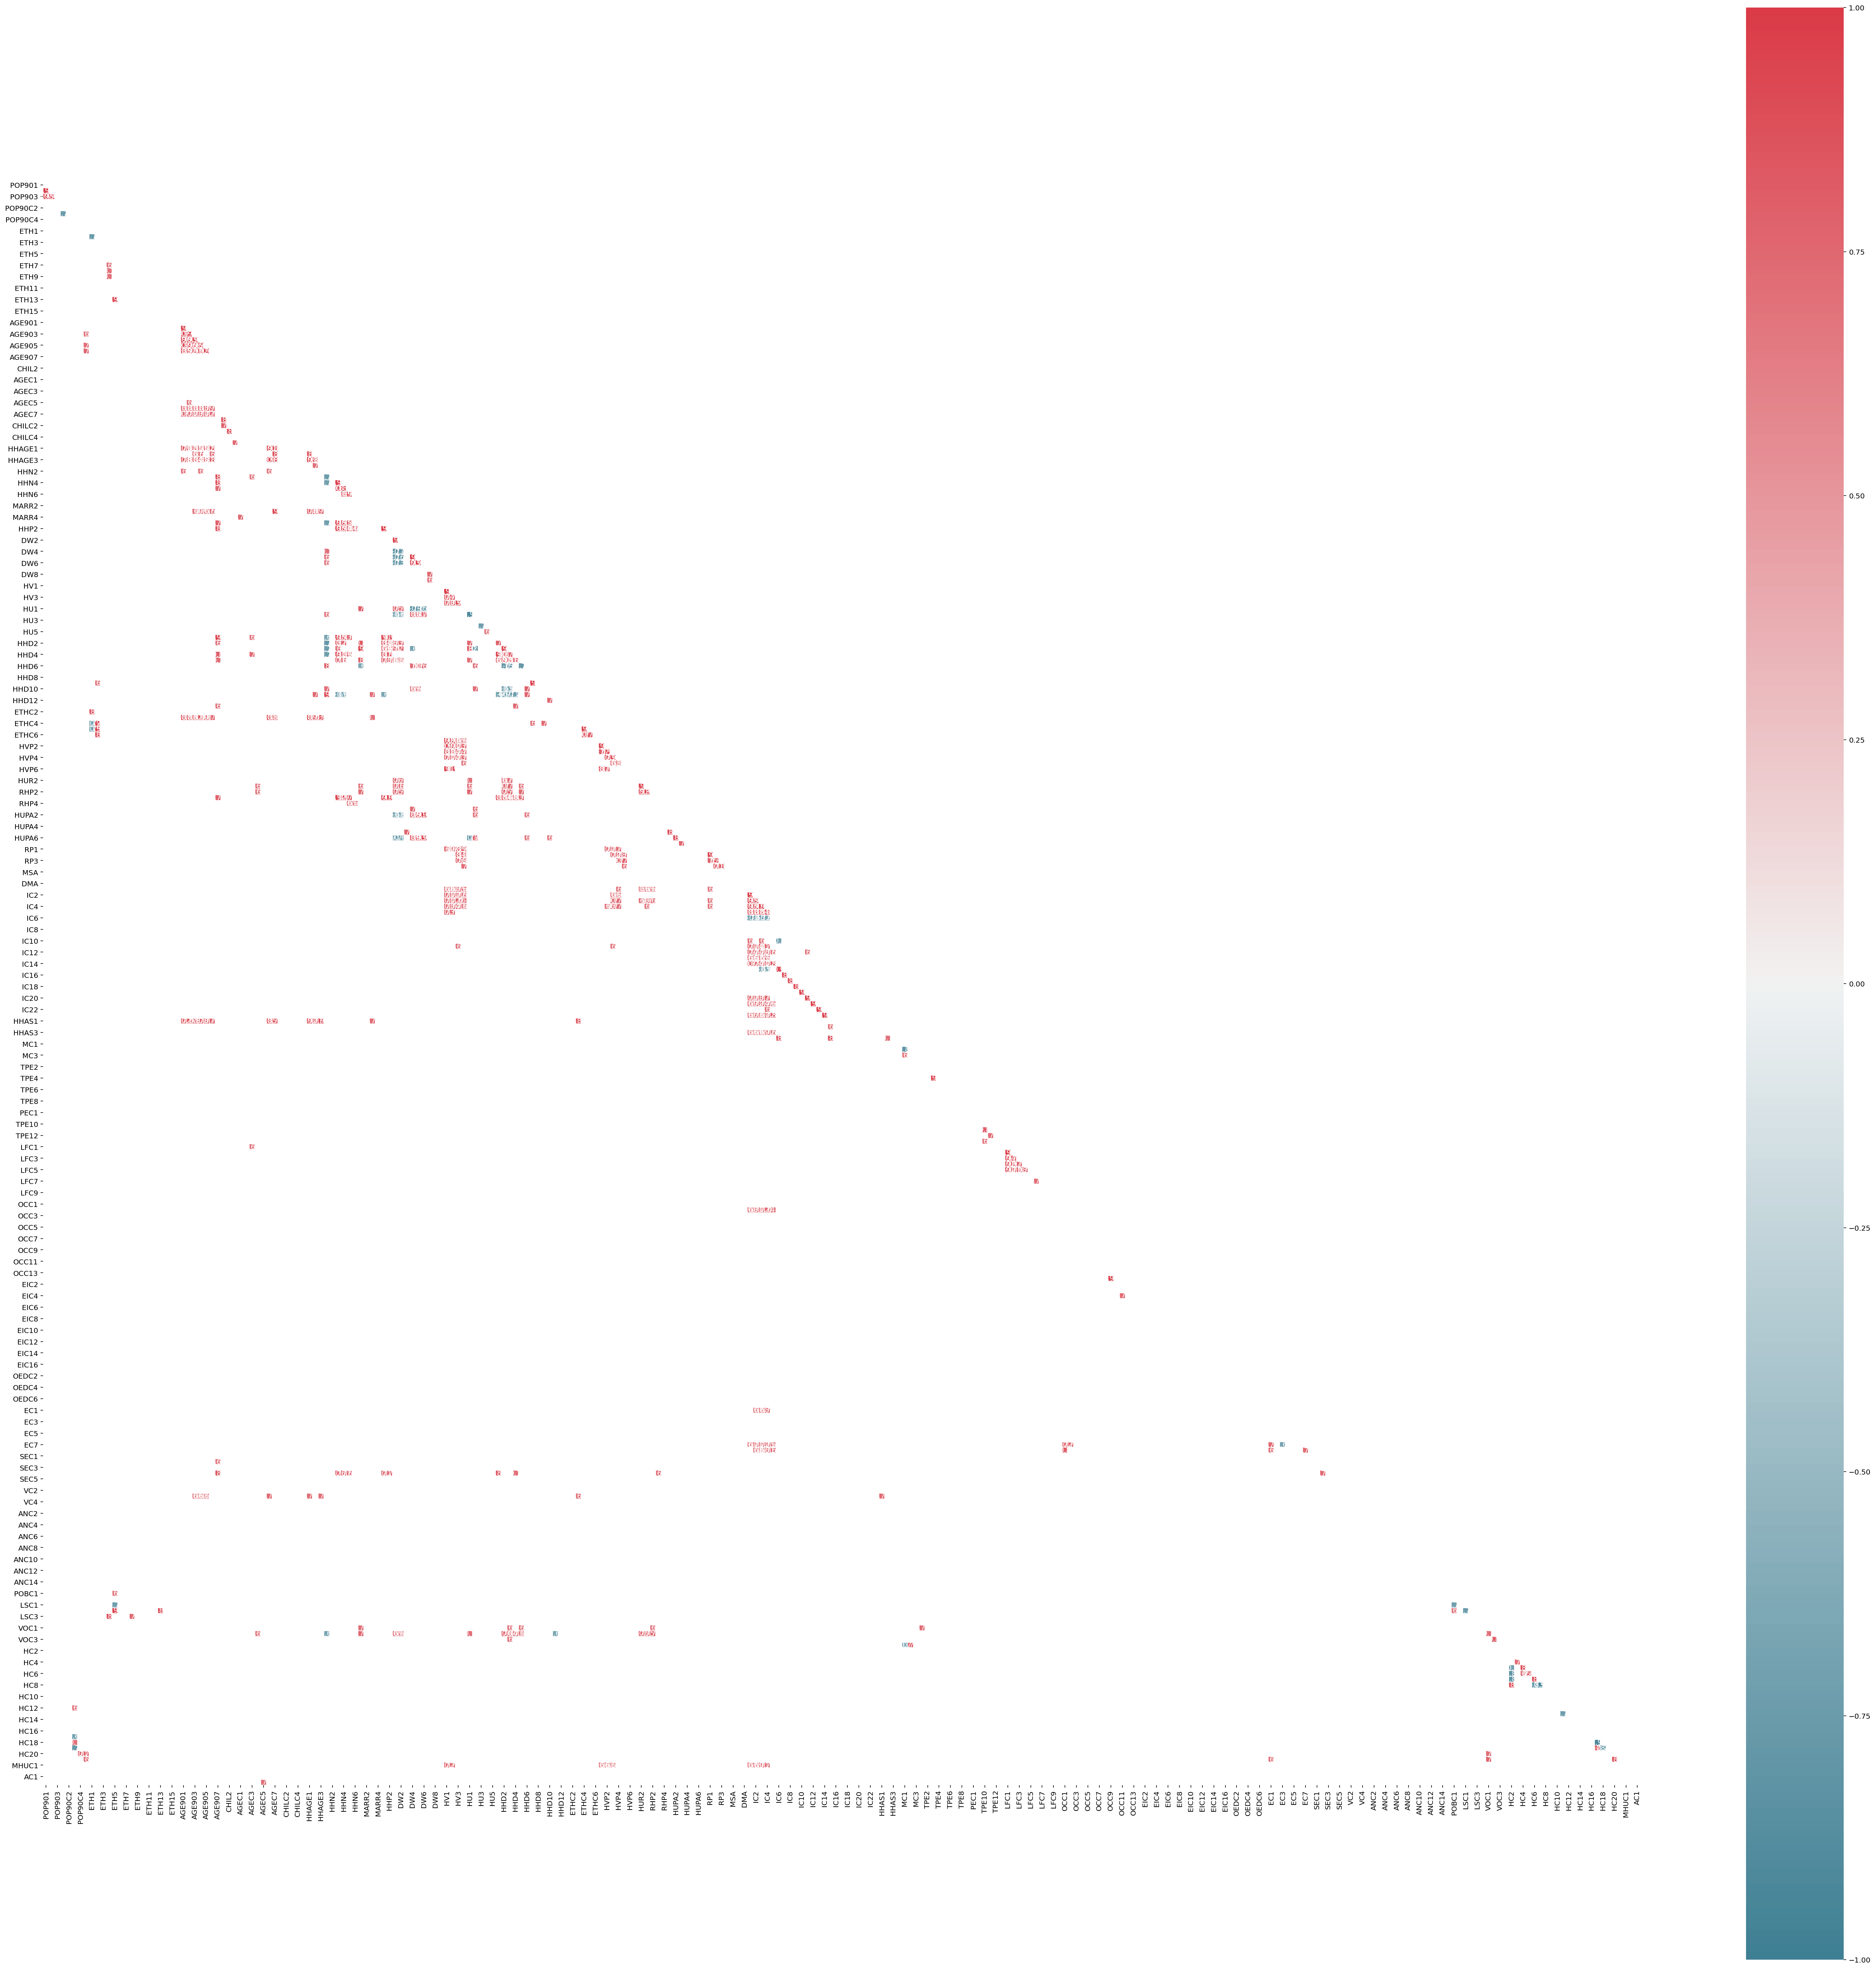

In [ ]:
mask=maskecreator(test)
THE_HEAT(mask)

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = neighbourhood.select_dtypes(include=numerics)

**Scaling** 

In [ ]:
neighbourhood_minmax = neighbourhood.copy()

In [ ]:
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(neighbourhood)
scaled_feat

array([[0.01005056, 0.01110831, 0.00937774, ..., 0.4       , 0.1010101 ,
        0.07070707],
       [0.03658524, 0.0395523 , 0.0281897 , ..., 0.8       , 0.06060606,
        0.05050505],
       [0.0709314 , 0.08583691, 0.07538909, ..., 0.4       , 0.06060606,
        0.05050505],
       ...,
       [0.00559265, 0.00551208, 0.00579047, ..., 0.4       , 0.03030303,
        0.11111111],
       [0.01768979, 0.01817723, 0.01434907, ..., 0.6       , 0.06060606,
        0.03030303],
       [0.03986788, 0.05015568, 0.03790639, ..., 0.6       , 0.07070707,
        0.04040404]])

In [ ]:
neighbourhood_minmax = scaled_feat
neighbourhood_minmax = pd.DataFrame(neighbourhood_minmax)
neighbourhood_minmax.columns = neighbourhood.columns
neighbourhood_minmax

,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,...,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2
0,0.010051,0.011108,0.009378,0.000000,0.353535,0.656566,0.474747,0.535354,0.929293,0.010101,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.113402,0.000000,0.000000,0.000000,0.464286,0.571429,0.607143,0.476190,0.595238,0.642857,0.333333,0.313131,0.424242,0.272727,0.111111,0.141414,0.181818,0.171717,0.131313,0.111111,...,0.000000,0.000000,0.000000,0.00,0.074074,0.0,0.030303,0.747475,0.888889,0.080808,0.000000,0.040404,0.969697,0.777778,0.191919,0.419355,0.596154,0.050505,0.141414,0.141414,0.313131,0.545455,0.464646,0.000000,0.000000,0.909091,0.000000,0.101010,0.000000,0.0,0.000000,0.333333,0.656566,0.404040,1.000000,1.000000,0.285714,0.4,0.101010,0.070707
1,0.036585,0.039552,0.028190,1.000000,0.000000,0.000000,0.505051,0.505051,0.676768,0.000000,0.000000,0.313131,0.060606,0.181818,0.027778,0.060606,0.059701,0.304348,0.0,0.0,0.020619,0.000000,0.012346,0.046512,0.404762,0.488095,0.511905,0.380952,0.500000,0.535714,0.426667,0.333333,0.464646,0.212121,0.131313,0.141414,0.333333,0.232323,0.101010,0.040404,...,0.010101,0.000000,0.057692,0.00,0.000000,0.0,0.424242,0.393939,0.505051,0.070707,0.272727,0.161616,1.000000,0.929293,0.535354,0.161290,0.192308,0.020202,0.262626,0.565657,0.979798,1.000000,0.000000,0.000000,0.000000,0.969697,0.000000,0.040404,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.952381,0.8,0.060606,0.050505
2,0.070931,0.085837,0.075389,0.000000,0.020202,0.989899,0.494949,0.515152,0.969697,0.020202,0.000000,0.000000,0.020202,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.020619,0.000000,0.000000,0.000000,0.416667,0.511905,0.547619,0.440476,0.535714,0.583333,0.306667,0.353535,0.404040,0.252525,0.131313,0.202020,0.191919,0.161616,0.131313,0.101010,...,0.000000,0.000000,0.000000,0.02,0.000000,0.0,0.020202,0.848485,0.969697,0.030303,0.000000,0.000000,0.929293,0.656566,0.292929,0.290323,0.423077,0.030303,0.121212,0.232323,0.505051,0.696970,0.313131,0.000000,0.000000,0.000000,0.060606,0.353535,0.444444,0.0,0.151515,0.222222,0.777778,0.171717,0.979798,0.929293,0.428571,0.4,0.060606,0.050505
3,0.006484,0.006732,0.006186,0.000000,0.080808,0.929293,0.545455,0.464646,0.616162,0.000000,0.000000,0.111111,0.323232,0.272727,0.027778,0.000000,0.000000,0.000000,0.0,0.0,0.319588,0.000000,0.000000,0.011628,0.380952,0.476190,0.523810,0.404762,0.511905,0.559524,0.333333,0.454545,0.353535,0.202020,0.151515,0.252525,0.171717,0.171717,0.121212,0.070707,...,0.000000,0.069767,0.000000,0.00,0.000000,0.0,0.292929,0.676768,0.565657,0.414141,0.030303,0.000000,0.949495,0.434343,0.272727,0.129032,0.730769,0.000000,0.101010,0.191919,0.393939,0.454545,0.555556,0.000000,0.000000,0.454545,0.222222,0.171717,0.000000,0.0,0.161616,0.232323,0.777778,0.222222,0.939394,0.898990,0.761905,0.4,0.060606,0.060606
4,0.025532,0.026382,0.021495,1.000000,0.000000,0.000000,0.464646,0.545455,0.020202,0.989899,0.000000,0.000000,0.010101,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.392857,0.535714,0.595238,0.428571,0.547619,0.595238,0.360000,0.343434,0.434343,0.232323,0.141414,0.212121,0.131313,0.151515,0.202020,0.121212,...,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.010101,0.656566,1.000000,0.000000,0.000000,0.000000,0.909091,0.454545,0.181818,0.806452,0.653846,0.000000,0.010101,0.030303,0.060606,0.333333,0.676768,0.000000,0.000000,0.090909,0.141414,0.727273,0.030303,0.0,0.000000,1.000000,0.010101,0.212121,1.000000,0.969697,0.285714,0.4,0.070707,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

To find out an eligible thershold of variance to make feature selection, we will see the distribution of the Standard Deviations of our scaled data, and possibly find outliers inside the standard deviation values.

In [ ]:
descneib = neighbourhood_minmax.describe().T

(0.0, 0.5)

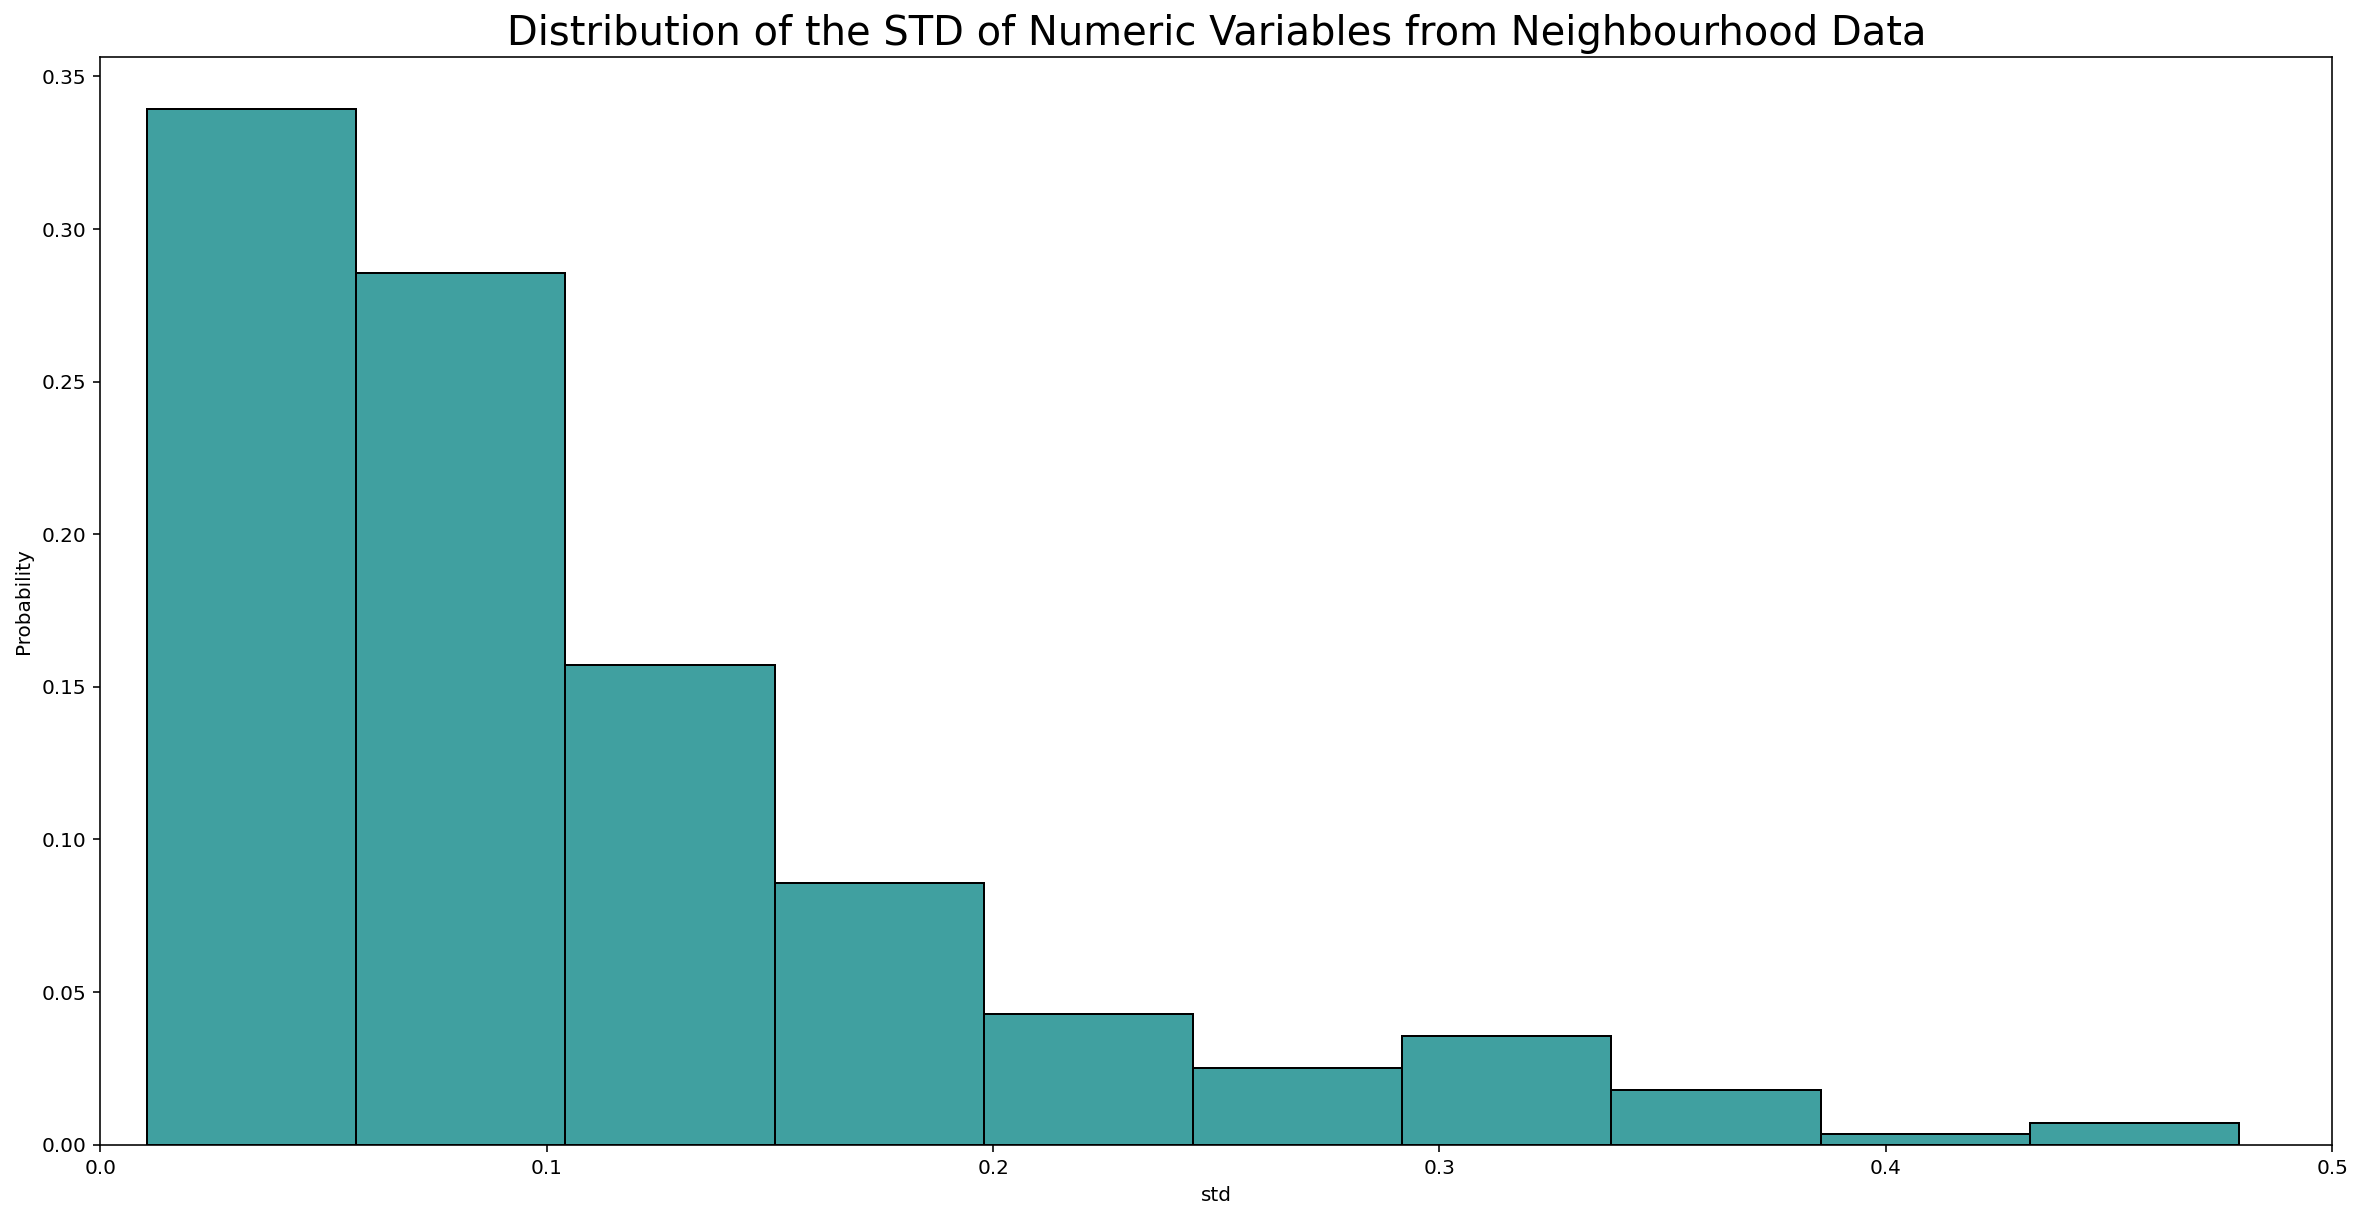

In [ ]:
plt.figure(figsize=(20, 10))
sns.histplot(data=descneib["std"] ,stat="probability", bins = 10,  color='teal')
plt.title(label = "Distribution of the STD of Numeric Variables from Neighbourhood Data", size=20)
plt.xlim(0, 0.5)

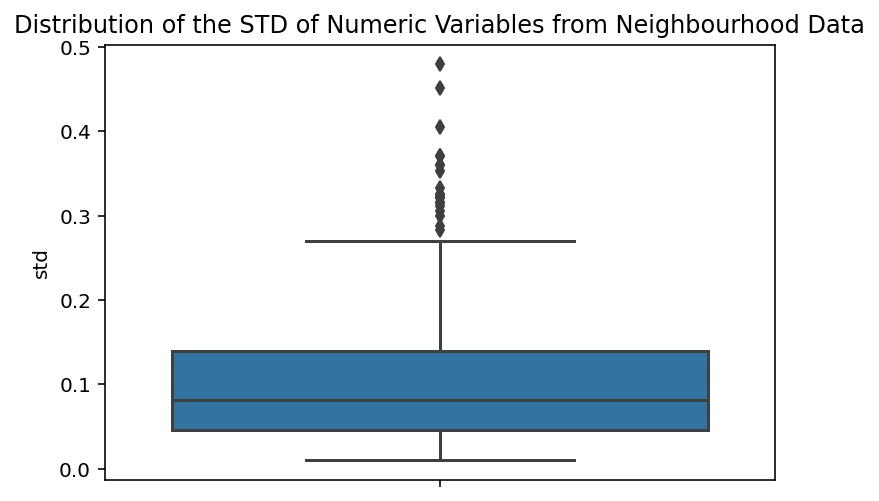

In [ ]:
sns.boxplot(y=descneib["std"])
plt.title("Distribution of the STD of Numeric Variables from Neighbourhood Data")
plt.show()

In [ ]:
selector = VarianceThreshold(threshold=0.01)
selector.fit_transform(neighbourhood_minmax).shape[1]

112

In [ ]:
threshold_n=0.05
selector = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
intermedio =selector.fit_transform(neighbourhood_minmax)
chosen_variables = neighbourhood_minmax[neighbourhood_minmax.columns[selector.get_support(indices=True)]] 

In [ ]:
newneighbourhood = neighbourhood[['POP901','POP90C2', 'POP90C3', 'POP90C4', 'POP90C5',
                               'ETH1', 'ETH3', 'ETH4', 'ETH5', 'ETH6','ETH10', 'ETH11', 'ETH12', 'ETH14', 'ETH15',
                               'AGE904','CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3','AGEC4', 'AGEC5', 'AGEC6', 'AGEC7',
                                 'HHN2', 'HHN4', 
                                'MARR1', 'MARR2', 'MARR3', 'MARR4',
                                'HHP2',
                               'DW2',
                               'HV2',
                               'HU1', 'HU4', 
                                'HHD2','HHD7', 'HHD8', 'HHD12',
                              'ETHC2', 'ETHC3', 'ETHC5',
                               'HVP2', 'HVP5',
                                'RHP2', 'RHP3', 'RHP4',
                               'HUPA1', 'HUPA3', 'HUPA4','HUPA6',
                                'RP2',
                               'IC3', 'IC9','IC17',
                                'IC22', 
                               'HHAS1','HHAS3', 'HHAS4',
                               'MC1', 
                               'TPE1', 'TPE2', 'TPE3', 'TPE5', 'TPE6', 'TPE7', 'TPE8', 'TPE9',
                                'TPE11',  'TPE13',
                               'LFC1', 'LFC6', 'LFC8', 'LFC9', 'LFC10',
                               'OCC1', 'OCC2','OCC3', 'OCC4', 'OCC5', 'OCC6', 'OCC7', 'OCC8', 'OCC9', 'OCC10','OCC11', 'OCC12', 'OCC13',
                                'EIC1', 'EIC2', 'EIC3', 'EIC4', 'EIC5','EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC10', 'EIC11', 'EIC12', 'EIC13','EIC14', 'EIC15', 'EIC16',
                                 'OEDC1', 'OEDC2', 'OEDC3', 'OEDC4','OEDC5', 'OEDC6', 'OEDC7',
                                 'EC2',  'EC4', 'EC5','EC6', 'EC7', 
                                'SEC1', 'SEC2', 'SEC3', 'SEC5',
                                'HC1', 'HC2', 'HC3',  'HC9', 'HC10', 'HC11', 'HC12',  'HC14',
                    'HC15', 'HC16', 'HC17', 'HC21',
                                'LSC1', 'LSC3', 'LSC4',
                                'VOC2',
                                'POBC1', 'POBC2',
                                'VC1', 'VC2','VC3','VC4',
                                'MHUC1','MHUC2',
                                'AC1', 'AC2',
                                'HUR1', 'HUR2',
                                'PEC1', 'PEC2',
                                'ANC1', 'ANC2', 'ANC3', 'ANC4', 'ANC5', 'ANC6','ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13',
                'ANC14', 'ANC15'
                               
                               
                             ]]

We will now split the remaining variables in 3 parts so we can analyse the correlations better

In [ ]:
newneighbourhood.shape

(95412, 167)

In [ ]:
newneighbourhood.iloc[:,50:100]

,HUPA3,HUPA4,HUPA6,RP2,IC3,IC9,IC17,IC22,HHAS1,HHAS3,HHAS4,MC1,TPE1,TPE2,TPE3,TPE5,TPE6,TPE7,TPE8,TPE9,TPE11,TPE13,LFC1,LFC6,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10
0,0,14,0,5,349,23,24,0,28,51,1,46,88,8,0,0,0,0,0,4,16,45,56,62,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5
1,0,4,0,91,1026,5,2,10,6,66,3,56,80,14,0,0,0,0,0,6,32,71,70,64,99,99,0,22,24,4,21,13,2,1,6,0,4,1,0,3,1,0,6,13,1,2,8,18,11,4
2,24,11,3,2,292,15,24,0,28,31,11,38,74,22,0,0,0,0,2,2,24,61,65,78,82,99,4,10,5,2,6,12,0,1,9,5,18,20,5,7,6,0,11,33,4,3,2,12,3,3
3,9,42,0,8,396,26,6,0,22,26,20,46,58,36,0,0,0,0,6,0,15,43,69,33,0,99,23,17,3,0,6,6,0,0,13,42,12,0,0,0,42,0,6,3,0,0,0,23,3,3
4,0,9,0,58,293,13,22,0,35,11,14,20,73,22,1,0,0,0,3,1,27,76,61,80,81,99,10,17,8,2,6,15,3,7,22,2,9,0,7,2,2,0,6,1,5,2,2,12,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,13,14,12,84,499,21,11,2,9,70,6,63,76,15,2,0,0,0,5,2,20,69,81,69,61,94,7,15,16,5,10,21,0,3,11,1,11,2,3,3,1,4,6,4,7,3,3,17,7,5
95408,10,7,0,26,802,6,8,3,8,61,7,83,80,4,4,0,0,0,6,5,32,61,73,48,99,0,0,18,31,0,13,17,0,1,2,4,6,0,3,5,1,8,8,9,3,7,9,13,9,6
95409,0,31,0,34,319,18,17,0,10,26,26,43,83,17,0,0,0,0,0,0,17,69,69,77,62,0,25,5,13,9,5,22,0,2,14,0,13,9,5,2,0,0,4,14,3,11,0,10,5,2
95410,0,12,0,88,568,18,15,3,25,46,3,43,80,11,0,0,0,1,2,6,28,52,73,70,99,99,0,14,16,6,16,17,0,2,12,1,11,2,0,2,1,0,2,22,4,6,4,19,4,7


In [ ]:
newneighbourhood.drop(columns = newneighbourhood.iloc[:,30:60].columns.to_list())


,POP901,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH3,ETH4,ETH5,ETH6,ETH10,ETH11,ETH12,ETH14,ETH15,AGE904,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,HHN2,HHN4,MARR1,MARR2,HHAS4,MC1,TPE1,TPE2,TPE3,TPE5,TPE6,TPE7,TPE8,TPE9,...,HC11,HC12,HC14,HC15,HC16,HC17,HC21,LSC1,LSC3,LSC4,VOC2,POBC1,POBC2,VC1,VC2,VC3,VC4,MHUC1,MHUC2,AC1,AC2,HUR1,HUR2,PEC1,PEC2,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15
0,992,35,65,47,53,92,0,0,11,0,0,0,0,0,0,40,31,42,27,11,14,18,17,13,11,15,33,28,61,7,1,46,88,8,0,0,0,0,0,4,...,90,0,0,0,0,33,99,88,0,4,77,3,74,34,23,18,16,6,2,10,7,1,61,1,13,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0
1,3611,0,0,50,50,67,0,31,6,4,14,0,0,0,1,32,33,46,21,13,14,33,23,10,4,2,21,55,69,4,3,56,80,14,0,0,0,0,0,6,...,96,0,0,0,0,99,99,50,27,16,92,42,39,55,10,11,0,20,4,6,5,0,83,0,2,0,2,0,3,1,1,2,3,1,1,0,3,0,0,0
2,7001,2,98,49,51,96,0,0,2,0,0,0,0,0,0,37,35,40,25,13,20,19,16,13,10,8,35,22,63,9,11,38,74,22,0,0,0,0,2,2,...,0,6,44,0,15,22,92,96,0,0,65,2,84,28,23,32,8,9,2,6,5,4,36,1,21,1,14,1,5,0,0,7,0,0,0,0,0,1,0,0
3,640,8,92,54,46,61,0,11,32,6,0,0,0,0,0,34,45,35,20,15,25,17,17,12,7,7,27,30,63,9,20,46,58,36,0,0,0,0,6,0,...,45,22,0,0,16,23,89,56,3,0,43,29,67,14,40,31,16,16,2,6,6,15,42,0,17,0,1,0,13,0,0,4,0,0,0,3,0,0,0,0
4,2520,0,0,46,54,2,0,0,1,0,0,0,0,0,0,36,34,43,23,14,21,13,15,20,12,5,26,36,42,17,14,20,73,22,1,0,0,0,3,1,...,9,14,3,0,0,99,96,99,0,0,45,1,65,9,16,53,20,6,2,7,11,2,45,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,27380,0,0,50,50,78,6,4,5,0,1,0,0,1,0,29,45,37,18,16,31,25,15,8,3,1,32,28,58,15,6,63,76,15,2,0,0,0,5,2,...,86,1,0,0,1,93,98,92,2,4,60,4,26,48,15,11,25,16,4,4,3,4,40,1,2,1,5,1,9,0,0,4,1,1,1,0,0,1,1,0
95408,1254,0,4,51,49,91,0,2,6,1,0,0,0,0,0,28,33,42,25,9,19,43,17,7,4,2,20,52,73,4,7,83,80,4,4,0,0,0,6,5,...,82,2,0,0,0,69,97,94,0,2,84,2,51,43,5,19,15,18,5,3,2,1,77,3,3,1,12,1,14,0,0,4,0,0,1,0,0,0,1,0
95409,552,0,0,53,47,82,0,1,9,0,0,0,0,0,0,30,46,38,17,13,34,21,9,9,9,4,29,31,45,19,26,43,83,17,0,0,0,0,0,0,...,97,0,0,0,4,99,99,92,3,0,42,6,82,46,0,20,20,5,2,3,11,2,45,0,25,2,8,0,14,0,0,0,1,0,0,0,0,1,0,0
95410,1746,0,0,47,53,92,1,5,8,0,1,0,0,0,0,36,38,40,22,12,21,21,18,12,7,9,26,41,56,9,3,43,80,11,0,0,0,1,2,6,...,99,0,0,0,0,99,99,83,4,5,85,14,50,35,18,20,8,12,3,6,3,0,90,0,24,0,3,1,9,0,0,2,6,1,2,0,0,0,0,0


In [ ]:
newneighbourhood[newneighbourhood.columns[~newneighbourhood.columns.iloc[:,30:60])]]

SyntaxError: ignored

In [ ]:
yes=corrmat(newneighbourhood.drop(columns = newneighbourhood.iloc[:,30:60].columns.to_list()))
mask_test=maskecreator(yes)

In [ ]:
# corrCV= chosen_variables.corr()
# plt.figure(figsize=(20,20))
# sns.heatmap(data = corrCV,  cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt='.2',  vmin=-1, vmax=1, center=0,square=True )
# plt.show()
THE_HEAT(mask_test)

In [ ]:
newneighbourhood.drop(columns = ["AGEC6","AGEC7","HHN2","ETHC3","ETHC2","ETHC5","MARR4","MARR3","RHP3","HHP2","HHD2","MARR1","RHP2","HU1","HVP2","IC22","HHAS3","OCC2","EIC1","EIC4","LSC1","VOC2"],inplace=True)

In [ ]:
newneighbourhood = newneighbourhood.drop(columns = ["HVP5", "HC12", "HC17", "POP90C4", "LSC3", "ETH5","VC4", "AC2", "DW2", "MHUC1"])

In [ ]:
yes=corrmat(newneighbourhood.iloc[:,0:30])
mask_test=maskecreator(yes)

In [ ]:
THE_HEAT(mask_test)

In [ ]:
chosen_variables.drop('MSA', inplace=True, axis=1)